# Cryptocurrency Price Prediction using LSTM, ARIMA, Prophet and ExponentialSmoothing methods

**Dataset** from [**Kaggle**](https://www.kaggle.com/datasets/sudalairajkumar/cryptocurrencypricehistory)

In [1]:
import os

import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.metrics import MeanSquaredError

## Dataset overview

In [2]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/cryptocurrencypricehistory/coin_ChainLink.csv
/kaggle/input/cryptocurrencypricehistory/coin_Cardano.csv
/kaggle/input/cryptocurrencypricehistory/coin_Solana.csv
/kaggle/input/cryptocurrencypricehistory/coin_Dogecoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Polkadot.csv
/kaggle/input/cryptocurrencypricehistory/coin_NEM.csv
/kaggle/input/cryptocurrencypricehistory/coin_XRP.csv
/kaggle/input/cryptocurrencypricehistory/coin_Ethereum.csv
/kaggle/input/cryptocurrencypricehistory/coin_Aave.csv
/kaggle/input/cryptocurrencypricehistory/coin_Bitcoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Cosmos.csv
/kaggle/input/cryptocurrencypricehistory/coin_Litecoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_Uniswap.csv
/kaggle/input/cryptocurrencypricehistory/coin_EOS.csv
/kaggle/input/cryptocurrencypricehistory/coin_BinanceCoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_CryptocomCoin.csv
/kaggle/input/cryptocurrencypricehistory/coin_USDCoin.csv
/kaggle/input/c

In [3]:
# Disable chained assignment warning
pd.options.mode.chained_assignment = None

# Set maximum number of columns to display
pd.options.display.max_columns = 999

# Define root directory for cryptocurrency price history data
RootDir = "/kaggle/input/cryptocurrencypricehistory"

# Specify the number of historical data points to consider
History = 60

# Function to read cryptocurrency data
def read_data():
    coin_no = 0  # Counter for the number of coins
    
    # Count the number of files in the root directory
    for name in os.listdir(RootDir):
        coin_no += 1
    
    max_length, min_length = 0, 1000000  # Initialize variables for maximum and minimum lengths
    
    # Iterate through the files in the root directory
    for name in os.listdir(RootDir):
        df = pd.read_csv(RootDir + "/" + name, parse_dates=['Date'])  # Read the CSV file into a DataFrame
        length = df.shape[0]  # Get the number of rows in the DataFrame
        if max_length < length:
            max_length = length  # Update maximum length if necessary
        if min_length > length:
            min_length = length  # Update minimum length if necessary
    
    data = np.zeros((coin_no, max_length))  # Create an array to store the data
    lengths = np.zeros(coin_no, dtype=int)  # Create an array to store the lengths of each coin's data
    
    i = 0  # Initialize index variable
    # Iterate through the files in the root directory again
    for name in os.listdir(RootDir):
        short_name = name[5:-4]  # Extract the short name of the coin
        df = pd.read_csv(RootDir + "/" + name, parse_dates=['Date'])  # Read the CSV file into a DataFrame
        length = df.shape[0]  # Get the number of rows in the DataFrame
        lengths[i] = length  # Store the length of the current coin's data
        print(i, short_name, length)  # Print the index, short name, and length of the current coin's data
        data[i, 0:length] = df['Close'].values  # Store the closing prices of the current coin as a sequence
        i += 1  # Increment the index
    
    return coin_no, lengths, data

# Call the read_data function to retrieve the cryptocurrency data
coin_no, lengths, data = read_data()

# Print the number of coins obtained
print("Got", coin_no, "coins.")

0 ChainLink 1385
1 Cardano 1374
2 Solana 452
3 Dogecoin 2760
4 Polkadot 320
5 NEM 2288
6 XRP 2893
7 Ethereum 2160
8 Aave 275
9 Bitcoin 2991
10 Cosmos 845
11 Litecoin 2991
12 Uniswap 292
13 EOS 1466
14 BinanceCoin 1442
15 CryptocomCoin 935
16 USDCoin 1002
17 Monero 2602
18 Tron 1392
19 WrappedBitcoin 888
20 Tether 2318
21 Iota 1484
22 Stellar 2527
Got 23 coins.


In [4]:
for coin in os.listdir('/kaggle/input/cryptocurrencypricehistory'):
    df = pd.read_csv('/kaggle/input/cryptocurrencypricehistory/' + coin)
    display(df)

SNo       Name Symbol                 Date       High        Low  \
0        1  Chainlink   LINK  2017-09-21 23:59:59   0.207892   0.155292   
1        2  Chainlink   LINK  2017-09-22 23:59:59   0.181675   0.139869   
2        3  Chainlink   LINK  2017-09-23 23:59:59   0.157440   0.126297   
3        4  Chainlink   LINK  2017-09-24 23:59:59   0.190250   0.130275   
4        5  Chainlink   LINK  2017-09-25 23:59:59   0.182637   0.158580   
...    ...        ...    ...                  ...        ...        ...   
1380  1381  Chainlink   LINK  2021-07-02 23:59:59  18.520256  17.305501   
1381  1382  Chainlink   LINK  2021-07-03 23:59:59  18.886003  17.898075   
1382  1383  Chainlink   LINK  2021-07-04 23:59:59  19.894503  18.028957   
1383  1384  Chainlink   LINK  2021-07-05 23:59:59  19.246891  17.814752   
1384  1385  Chainlink   LINK  2021-07-06 23:59:59  20.240997  18.351877   

           Open      Close        Volume     Marketcap  
0      0.189132   0.169680  2.126270e+06  5.938800e+07  
1      0.169826   0.150503  1.423220e+06  5.267605e+07  
2      0.149562   0.131129  1.186670e+06  4.589515e+07  
3      0.131110   0.170278  1.025740e+06  5.959730e+07  
4      0.170636   0.182198  1.021370e+06  6.376930e+07  
...         ...        ...           ...           ...  
1380  18.220669  18.283561  6.865419e+08  7.990091e+09  
1381  18.285458  18.538818  5.090763e+08  8.101641e+09  
1382  18.548805  19.262838  6.802681e+08  8.418044e+09  
1383  19.246891  18.371589  6.986191e+08  8.028560e+09  
1384  18.351877  20.080466  1.156986e+09  8.775356e+09  

[1385 rows x 10 columns]

SNo     Name Symbol                 Date      High       Low      Open  \
0        1  Cardano    ADA  2017-10-02 23:59:59  0.030088  0.019969  0.024607   
1        2  Cardano    ADA  2017-10-03 23:59:59  0.027425  0.020690  0.025757   
2        3  Cardano    ADA  2017-10-04 23:59:59  0.022806  0.020864  0.020864   
3        4  Cardano    ADA  2017-10-05 23:59:59  0.022154  0.020859  0.021951   
4        5  Cardano    ADA  2017-10-06 23:59:59  0.021542  0.018360  0.021359   
...    ...      ...    ...                  ...       ...       ...       ...   
1369  1370  Cardano    ADA  2021-07-02 23:59:59  1.394397  1.286607  1.332942   
1370  1371  Cardano    ADA  2021-07-03 23:59:59  1.441714  1.359664  1.394152   
1371  1372  Cardano    ADA  2021-07-04 23:59:59  1.493717  1.382153  1.404008   
1372  1373  Cardano    ADA  2021-07-05 23:59:59  1.461221  1.379284  1.461221   
1373  1374  Cardano    ADA  2021-07-06 23:59:59  1.456887  1.393282  1.404712   

         Close        Volume     Marketcap  
0     0.025932  5.764130e+07  6.288991e+08  
1     0.020816  1.699780e+07  5.396927e+08  
2     0.021931  9.000050e+06  5.686195e+08  
3     0.021489  5.562510e+06  5.571390e+08  
4     0.018539  7.780710e+06  4.806646e+08  
...        ...           ...           ...  
1369  1.394397  2.159410e+09  4.454587e+10  
1370  1.406836  2.028094e+09  4.494324e+10  
1371  1.458184  1.806362e+09  4.658364e+10  
1372  1.404898  1.759461e+09  4.488134e+10  
1373  1.418053  1.477700e+09  4.530158e+10  

[1374 rows x 10 columns]

SNo    Name Symbol                 Date       High        Low       Open  \
0      1  Solana    SOL  2020-04-11 23:59:59   1.049073   0.765020   0.951054   
1      2  Solana    SOL  2020-04-12 23:59:59   0.956670   0.762426   0.785448   
2      3  Solana    SOL  2020-04-13 23:59:59   0.891603   0.773976   0.890760   
3      4  Solana    SOL  2020-04-14 23:59:59   0.796472   0.628169   0.777832   
4      5  Solana    SOL  2020-04-15 23:59:59   0.704964   0.621531   0.669289   
..   ...     ...    ...                  ...        ...        ...        ...   
447  448  Solana    SOL  2021-07-02 23:59:59  34.031786  31.479924  33.306310   
448  449  Solana    SOL  2021-07-03 23:59:59  35.404770  33.298475  34.015575   
449  450  Solana    SOL  2021-07-04 23:59:59  35.502372  33.555737  34.495117   
450  451  Solana    SOL  2021-07-05 23:59:59  34.461824  32.482692  34.282550   
451  452  Solana    SOL  2021-07-06 23:59:59  34.978319  32.930307  32.930307   

         Close        Volume     Marketcap  
0     0.776819  4.386244e+07  0.000000e+00  
1     0.882507  3.873690e+07  0.000000e+00  
2     0.777832  1.821129e+07  0.000000e+00  
3     0.661925  1.674761e+07  0.000000e+00  
4     0.646651  1.307528e+07  0.000000e+00  
..         ...           ...           ...  
447  34.020482  4.402988e+08  9.275257e+09  
448  34.478816  3.270200e+08  9.400216e+09  
449  34.310601  3.034205e+08  9.354354e+09  
450  32.984588  3.138393e+08  8.992833e+09  
451  34.269140  3.653360e+08  9.343050e+09  

[452 rows x 10 columns]

SNo      Name Symbol                 Date      High       Low  \
0        1  Dogecoin   DOGE  2013-12-16 23:59:59  0.000866  0.000150   
1        2  Dogecoin   DOGE  2013-12-17 23:59:59  0.000289  0.000116   
2        3  Dogecoin   DOGE  2013-12-18 23:59:59  0.000362  0.000205   
3        4  Dogecoin   DOGE  2013-12-19 23:59:59  0.001520  0.000328   
4        5  Dogecoin   DOGE  2013-12-20 23:59:59  0.001143  0.000662   
...    ...       ...    ...                  ...       ...       ...   
2755  2756  Dogecoin   DOGE  2021-07-02 23:59:59  0.247997  0.238848   
2756  2757  Dogecoin   DOGE  2021-07-03 23:59:59  0.250214  0.242454   
2757  2758  Dogecoin   DOGE  2021-07-04 23:59:59  0.252567  0.243425   
2758  2759  Dogecoin   DOGE  2021-07-05 23:59:59  0.246419  0.227838   
2759  2760  Dogecoin   DOGE  2021-07-06 23:59:59  0.241910  0.229842   

          Open     Close        Volume     Marketcap  
0     0.000299  0.000205  0.000000e+00  1.509085e+06  
1     0.000207  0.000269  0.000000e+00  2.169688e+06  
2     0.000267  0.000362  0.000000e+00  3.188943e+06  
3     0.000395  0.001162  0.000000e+00  1.115034e+07  
4     0.001143  0.000704  0.000000e+00  7.284337e+06  
...        ...       ...           ...           ...  
2755  0.243982  0.245264  1.321471e+09  3.194925e+10  
2756  0.245106  0.246411  9.170158e+08  3.210491e+10  
2757  0.246425  0.246483  9.735115e+08  3.211767e+10  
2758  0.246419  0.231614  1.267949e+09  3.018344e+10  
2759  0.231216  0.234422  1.265920e+09  3.055252e+10  

[2760 rows x 10 columns]

SNo      Name Symbol                 Date       High        Low  \
0      1  Polkadot    DOT  2020-08-21 23:59:59   3.090093   2.730919   
1      2  Polkadot    DOT  2020-08-22 23:59:59   4.510613   2.816762   
2      3  Polkadot    DOT  2020-08-23 23:59:59   4.487058   3.716271   
3      4  Polkadot    DOT  2020-08-24 23:59:59   4.783158   3.812670   
4      5  Polkadot    DOT  2020-08-25 23:59:59   5.760775   4.501223   
..   ...       ...    ...                  ...        ...        ...   
315  316  Polkadot    DOT  2021-07-02 23:59:59  15.469187  14.675115   
316  317  Polkadot    DOT  2021-07-03 23:59:59  15.776978  15.068263   
317  318  Polkadot    DOT  2021-07-04 23:59:59  16.579445  15.221813   
318  319  Polkadot    DOT  2021-07-05 23:59:59  15.996540  14.788740   
319  320  Polkadot    DOT  2021-07-06 23:59:59  16.162344  15.210810   

          Open      Close        Volume     Marketcap  
0     2.896923   2.875028  4.931314e+07  0.000000e+00  
1     2.878570   4.484690  4.858011e+08  0.000000e+00  
2     4.487058   3.967066  3.207495e+08  0.000000e+00  
3     3.987413   4.602614  4.076902e+08  0.000000e+00  
4     4.584953   5.523393  8.988475e+08  0.000000e+00  
..         ...        ...           ...           ...  
315  15.219061  15.340774  7.531948e+08  1.468349e+10  
316  15.321934  15.553716  7.112351e+08  1.489035e+10  
317  15.553584  16.014026  7.520759e+08  1.533547e+10  
318  15.996540  15.235582  8.448446e+08  1.459323e+10  
319  15.240785  16.143564  1.001573e+09  1.546772e+10  

[320 rows x 10 columns]

SNo Name Symbol                 Date      High       Low      Open  \
0        1  NEM    XEM  2015-04-02 23:59:59  0.000323  0.000227  0.000242   
1        2  NEM    XEM  2015-04-03 23:59:59  0.000330  0.000291  0.000309   
2        3  NEM    XEM  2015-04-04 23:59:59  0.000318  0.000251  0.000310   
3        4  NEM    XEM  2015-04-05 23:59:59  0.000283  0.000218  0.000272   
4        5  NEM    XEM  2015-04-06 23:59:59  0.000299  0.000229  0.000232   
...    ...  ...    ...                  ...       ...       ...       ...   
2283  2284  NEM    XEM  2021-07-02 23:59:59  0.131455  0.123406  0.128181   
2284  2285  NEM    XEM  2021-07-03 23:59:59  0.136359  0.128350  0.131542   
2285  2286  NEM    XEM  2021-07-04 23:59:59  0.140061  0.129912  0.134751   
2286  2287  NEM    XEM  2021-07-05 23:59:59  0.137633  0.126915  0.137633   
2287  2288  NEM    XEM  2021-07-06 23:59:59  0.136318  0.128804  0.130591   

         Close        Volume     Marketcap  
0     0.000314  2.854940e+04  2.823534e+06  
1     0.000310  2.067790e+04  2.792457e+06  
2     0.000277  2.355020e+04  2.488770e+06  
3     0.000232  2.680020e+04  2.087388e+06  
4     0.000289  2.251150e+04  2.598354e+06  
...        ...           ...           ...  
2283  0.131455  3.983899e+07  1.183097e+09  
2284  0.134756  4.164779e+07  1.212805e+09  
2285  0.137617  4.953784e+07  1.238554e+09  
2286  0.130602  5.999584e+07  1.175421e+09  
2287  0.133591  6.635341e+07  1.202315e+09  

[2288 rows x 10 columns]

SNo Name Symbol                 Date      High       Low      Open  \
0        1  XRP    XRP  2013-08-05 23:59:59  0.005980  0.005613  0.005875   
1        2  XRP    XRP  2013-08-06 23:59:59  0.005661  0.004629  0.005637   
2        3  XRP    XRP  2013-08-07 23:59:59  0.004682  0.004333  0.004669   
3        4  XRP    XRP  2013-08-08 23:59:59  0.004424  0.004175  0.004397   
4        5  XRP    XRP  2013-08-09 23:59:59  0.004367  0.004253  0.004257   
...    ...  ...    ...                  ...       ...       ...       ...   
2888  2889  XRP    XRP  2021-07-02 23:59:59  0.667287  0.634726  0.659890   
2889  2890  XRP    XRP  2021-07-03 23:59:59  0.683677  0.644653  0.655639   
2890  2891  XRP    XRP  2021-07-04 23:59:59  0.707783  0.665802  0.673218   
2891  2892  XRP    XRP  2021-07-05 23:59:59  0.695653  0.648492  0.695653   
2892  2893  XRP    XRP  2021-07-06 23:59:59  0.679923  0.652676  0.653055   

         Close        Volume     Marketcap  
0     0.005613  0.000000e+00  4.387916e+07  
1     0.004680  0.000000e+00  3.659101e+07  
2     0.004417  0.000000e+00  3.453412e+07  
3     0.004254  0.000000e+00  3.325863e+07  
4     0.004291  0.000000e+00  3.354750e+07  
...        ...           ...           ...  
2888  0.656763  2.061607e+09  3.030759e+10  
2889  0.672888  1.872820e+09  3.105172e+10  
2890  0.694945  1.885242e+09  3.206960e+10  
2891  0.654300  2.076373e+09  3.019395e+10  
2892  0.665402  1.938959e+09  3.072284e+10  

[2893 rows x 10 columns]

SNo      Name Symbol                 Date         High          Low  \
0        1  Ethereum    ETH  2015-08-08 23:59:59     2.798810     0.714725   
1        2  Ethereum    ETH  2015-08-09 23:59:59     0.879810     0.629191   
2        3  Ethereum    ETH  2015-08-10 23:59:59     0.729854     0.636546   
3        4  Ethereum    ETH  2015-08-11 23:59:59     1.131410     0.663235   
4        5  Ethereum    ETH  2015-08-12 23:59:59     1.289940     0.883608   
...    ...       ...    ...                  ...          ...          ...   
2155  2156  Ethereum    ETH  2021-07-02 23:59:59  2155.596496  2021.824808   
2156  2157  Ethereum    ETH  2021-07-03 23:59:59  2237.567155  2117.590013   
2157  2158  Ethereum    ETH  2021-07-04 23:59:59  2384.286857  2190.837703   
2158  2159  Ethereum    ETH  2021-07-05 23:59:59  2321.922836  2163.041394   
2159  2160  Ethereum    ETH  2021-07-06 23:59:59  2346.294874  2197.919385   

             Open        Close        Volume     Marketcap  
0        2.793760     0.753325  6.741880e+05  4.548689e+07  
1        0.706136     0.701897  5.321700e+05  4.239957e+07  
2        0.713989     0.708448  4.052830e+05  4.281836e+07  
3        0.708087     1.067860  1.463100e+06  6.456929e+07  
4        1.058750     1.217440  2.150620e+06  7.364501e+07  
...           ...          ...           ...           ...  
2155  2109.892677  2150.040364  3.179621e+10  2.505527e+11  
2156  2150.835025  2226.114282  1.743336e+10  2.594475e+11  
2157  2226.550382  2321.724112  1.878711e+10  2.706217e+11  
2158  2321.922836  2198.582464  2.010379e+10  2.562978e+11  
2159  2197.919385  2324.679449  2.089186e+10  2.710286e+11  

[2160 rows x 10 columns]

SNo  Name Symbol                 Date        High         Low  \
0      1  Aave   AAVE  2020-10-05 23:59:59   55.112358   49.787900   
1      2  Aave   AAVE  2020-10-06 23:59:59   53.402270   40.734578   
2      3  Aave   AAVE  2020-10-07 23:59:59   42.408314   35.970690   
3      4  Aave   AAVE  2020-10-08 23:59:59   44.902511   36.696057   
4      5  Aave   AAVE  2020-10-09 23:59:59   47.569533   43.291776   
..   ...   ...    ...                  ...         ...         ...   
270  271  Aave   AAVE  2021-07-02 23:59:59  234.483957  215.951539   
271  272  Aave   AAVE  2021-07-03 23:59:59  265.107342  228.485206   
272  273  Aave   AAVE  2021-07-04 23:59:59  289.001124  248.285491   
273  274  Aave   AAVE  2021-07-05 23:59:59  317.387234  263.433881   
274  275  Aave   AAVE  2021-07-06 23:59:59  346.714780  307.997525   

           Open       Close        Volume     Marketcap  
0     52.675035   53.219243  0.000000e+00  8.912813e+07  
1     53.291969   42.401599  5.830915e+05  7.101144e+07  
2     42.399947   40.083976  6.828342e+05  6.713004e+07  
3     39.885262   43.764463  1.658817e+06  2.202651e+08  
4     43.764463   46.817744  8.155377e+05  2.356322e+08  
..          ...         ...           ...           ...  
270  230.814119  233.948437  2.566395e+08  3.001542e+09  
271  234.208478  259.655225  3.853778e+08  3.331546e+09  
272  259.399426  277.038792  4.275719e+08  3.555054e+09  
273  277.110533  307.829079  7.931409e+08  3.950269e+09  
274  307.997525  316.898507  9.887055e+08  4.066776e+09  

[275 rows x 10 columns]

SNo     Name Symbol                 Date          High           Low  \
0        1  Bitcoin    BTC  2013-04-29 23:59:59    147.488007    134.000000   
1        2  Bitcoin    BTC  2013-04-30 23:59:59    146.929993    134.050003   
2        3  Bitcoin    BTC  2013-05-01 23:59:59    139.889999    107.720001   
3        4  Bitcoin    BTC  2013-05-02 23:59:59    125.599998     92.281898   
4        5  Bitcoin    BTC  2013-05-03 23:59:59    108.127998     79.099998   
...    ...      ...    ...                  ...           ...           ...   
2986  2987  Bitcoin    BTC  2021-07-02 23:59:59  33939.588699  32770.680780   
2987  2988  Bitcoin    BTC  2021-07-03 23:59:59  34909.259899  33402.696536   
2988  2989  Bitcoin    BTC  2021-07-04 23:59:59  35937.567147  34396.477458   
2989  2990  Bitcoin    BTC  2021-07-05 23:59:59  35284.344430  33213.661034   
2990  2991  Bitcoin    BTC  2021-07-06 23:59:59  35038.536363  33599.916169   

              Open         Close        Volume     Marketcap  
0       134.444000    144.539993  0.000000e+00  1.603769e+09  
1       144.000000    139.000000  0.000000e+00  1.542813e+09  
2       139.000000    116.989998  0.000000e+00  1.298955e+09  
3       116.379997    105.209999  0.000000e+00  1.168517e+09  
4       106.250000     97.750000  0.000000e+00  1.085995e+09  
...            ...           ...           ...           ...  
2986  33549.600177  33897.048590  3.872897e+10  6.354508e+11  
2987  33854.421362  34668.548402  2.438396e+10  6.499397e+11  
2988  34665.564866  35287.779766  2.492431e+10  6.615748e+11  
2989  35284.344430  33746.002456  2.672155e+10  6.326962e+11  
2990  33723.509655  34235.193451  2.650126e+10  6.418992e+11  

[2991 rows x 10 columns]

SNo    Name Symbol                 Date       High        Low       Open  \
0      1  Cosmos   ATOM  2019-03-15 23:59:59   7.715249   6.432468   6.633174   
1      2  Cosmos   ATOM  2019-03-16 23:59:59   8.305615   6.694531   7.507990   
2      3  Cosmos   ATOM  2019-03-17 23:59:59   7.357443   4.727895   7.357443   
3      4  Cosmos   ATOM  2019-03-18 23:59:59   5.229982   4.828242   4.828242   
4      5  Cosmos   ATOM  2019-03-19 23:59:59   5.206172   4.794501   5.099978   
..   ...     ...    ...                  ...        ...        ...        ...   
840  841  Cosmos   ATOM  2021-07-02 23:59:59  11.764925  10.543935  11.048080   
841  842  Cosmos   ATOM  2021-07-03 23:59:59  12.198276  11.540298  11.791034   
842  843  Cosmos   ATOM  2021-07-04 23:59:59  12.433965  11.520693  11.799601   
843  844  Cosmos   ATOM  2021-07-05 23:59:59  13.968271  11.955753  12.320437   
844  845  Cosmos   ATOM  2021-07-06 23:59:59  14.020420  12.823983  13.558099   

         Close        Volume     Marketcap  
0     7.504351  6.057301e+06  0.000000e+00  
1     7.383882  3.477393e+06  0.000000e+00  
2     4.776164  2.653565e+06  0.000000e+00  
3     5.110341  2.567201e+06  0.000000e+00  
4     4.821883  3.891084e+06  0.000000e+00  
..         ...           ...           ...  
840  11.764925  1.891418e+08  2.559039e+09  
841  11.817927  1.551317e+08  2.571184e+09  
842  12.263548  1.449177e+08  2.668775e+09  
843  13.548475  4.489358e+08  2.949102e+09  
844  13.159371  2.537822e+08  2.865093e+09  

[845 rows x 10 columns]

SNo      Name Symbol                 Date        High         Low  \
0        1  Litecoin    LTC  2013-04-29 23:59:59    4.573600    4.225640   
1        2  Litecoin    LTC  2013-04-30 23:59:59    4.572380    4.168960   
2        3  Litecoin    LTC  2013-05-01 23:59:59    4.356860    3.520290   
3        4  Litecoin    LTC  2013-05-02 23:59:59    4.039300    3.007170   
4        5  Litecoin    LTC  2013-05-03 23:59:59    3.453610    2.395940   
...    ...       ...    ...                  ...         ...         ...   
2986  2987  Litecoin    LTC  2021-07-02 23:59:59  138.787700  130.935471   
2987  2988  Litecoin    LTC  2021-07-03 23:59:59  141.356011  134.945288   
2988  2989  Litecoin    LTC  2021-07-04 23:59:59  147.836059  137.096427   
2989  2990  Litecoin    LTC  2021-07-05 23:59:59  144.849333  134.960263   
2990  2991  Litecoin    LTC  2021-07-06 23:59:59  142.703568  135.924837   

            Open       Close        Volume     Marketcap  
0       4.366760    4.383900  0.000000e+00  7.538896e+07  
1       4.403520    4.296490  0.000000e+00  7.402092e+07  
2       4.289540    3.801010  0.000000e+00  6.560460e+07  
3       3.780020    3.371980  0.000000e+00  5.828798e+07  
4       3.390440    3.044910  0.000000e+00  5.269485e+07  
...          ...         ...           ...           ...  
2986  137.299274  136.943696  1.418981e+09  9.141322e+09  
2987  136.930584  140.279688  1.236494e+09  9.364008e+09  
2988  140.317998  144.905849  1.431657e+09  9.672815e+09  
2989  144.849333  138.073246  1.338246e+09  9.216723e+09  
2990  137.951668  138.985636  1.504907e+09  9.277627e+09  

[2991 rows x 10 columns]

SNo     Name Symbol                 Date       High        Low  \
0      1  Uniswap    UNI  2020-09-18 23:59:59   8.438537   3.261757   
1      2  Uniswap    UNI  2020-09-19 23:59:59   7.443275   5.321795   
2      3  Uniswap    UNI  2020-09-20 23:59:59   6.050326   4.720210   
3      4  Uniswap    UNI  2020-09-21 23:59:59   5.622155   4.160743   
4      5  Uniswap    UNI  2020-09-22 23:59:59   4.554092   3.755040   
..   ...      ...    ...                  ...        ...        ...   
287  288  Uniswap    UNI  2021-07-02 23:59:59  18.243571  16.983818   
288  289  Uniswap    UNI  2021-07-03 23:59:59  19.524757  17.849987   
289  290  Uniswap    UNI  2021-07-04 23:59:59  21.481411  18.947371   
290  291  Uniswap    UNI  2021-07-05 23:59:59  20.867785  19.180908   
291  292  Uniswap    UNI  2021-07-06 23:59:59  23.188558  20.075544   

          Open      Close        Volume     Marketcap  
0     3.488153   6.897257  6.061110e+09  6.681116e+08  
1     6.945577   5.724464  2.447471e+09  5.545076e+08  
2     5.720515   5.244195  1.554144e+09  5.079857e+08  
3     5.244195   4.266079  1.329464e+09  4.132392e+08  
4     4.275014   3.905138  8.162827e+08  3.782762e+08  
..         ...        ...           ...           ...  
287  17.833072  18.241726  3.070457e+08  1.049364e+10  
288  18.227339  19.524757  3.448554e+08  1.146609e+10  
289  19.479936  20.771874  5.404909e+08  1.219861e+10  
290  20.767419  20.095181  5.452744e+08  1.180130e+10  
291  20.088390  22.400186  8.151239e+08  1.315501e+10  

[292 rows x 10 columns]

SNo Name Symbol                 Date      High       Low      Open  \
0        1  EOS    EOS  2017-07-02 23:59:59  2.877510  0.822648  0.996521   
1        2  EOS    EOS  2017-07-03 23:59:59  5.395970  2.632310  2.717390   
2        3  EOS    EOS  2017-07-04 23:59:59  4.191240  2.933450  4.098010   
3        4  EOS    EOS  2017-07-05 23:59:59  3.523500  2.730130  3.356000   
4        5  EOS    EOS  2017-07-06 23:59:59  3.867470  3.007830  3.014260   
...    ...  ...    ...                  ...       ...       ...       ...   
1461  1462  EOS    EOS  2021-07-02 23:59:59  4.000508  3.751986  3.930561   
1462  1463  EOS    EOS  2021-07-03 23:59:59  4.060837  3.859586  3.926595   
1463  1464  EOS    EOS  2021-07-04 23:59:59  4.181861  3.952532  4.048645   
1464  1465  EOS    EOS  2021-07-05 23:59:59  4.061888  3.773130  4.061888   
1465  1466  EOS    EOS  2021-07-06 23:59:59  4.004299  3.797596  3.814236   

         Close        Volume     Marketcap  
0     2.710050  3.204520e+08  0.000000e+00  
1     4.086640  4.149500e+08  6.549307e+08  
2     3.372000  2.185590e+08  5.501552e+08  
3     3.003230  1.243390e+08  5.006264e+08  
4     3.361330  1.774630e+08  5.683615e+08  
...        ...           ...           ...  
1461  3.934325  1.014258e+09  3.756672e+09  
1462  4.046421  7.302703e+08  3.863820e+09  
1463  4.059930  8.086025e+08  3.876834e+09  
1464  3.819266  8.004033e+08  3.647131e+09  
1465  3.882325  6.967875e+08  3.707457e+09  

[1466 rows x 10 columns]

SNo          Name Symbol                 Date        High         Low  \
0        1  Binance Coin    BNB  2017-07-26 23:59:59    0.109013    0.099266   
1        2  Binance Coin    BNB  2017-07-27 23:59:59    0.108479    0.100888   
2        3  Binance Coin    BNB  2017-07-28 23:59:59    0.109019    0.101473   
3        4  Binance Coin    BNB  2017-07-29 23:59:59    0.111264    0.101108   
4        5  Binance Coin    BNB  2017-07-30 23:59:59    0.108138    0.103162   
...    ...           ...    ...                  ...         ...         ...   
1437  1438  Binance Coin    BNB  2021-07-02 23:59:59  290.621683  277.350302   
1438  1439  Binance Coin    BNB  2021-07-03 23:59:59  302.605867  283.434010   
1439  1440  Binance Coin    BNB  2021-07-04 23:59:59  314.713019  292.787370   
1440  1441  Binance Coin    BNB  2021-07-05 23:59:59  307.684855  293.523465   
1441  1442  Binance Coin    BNB  2021-07-06 23:59:59  321.520965  302.195584   

            Open       Close        Volume     Marketcap  
0       0.105893    0.105138  2.003950e+05  1.051380e+07  
1       0.105108    0.107737  3.444990e+05  1.077370e+07  
2       0.107632    0.104067  3.425680e+05  1.040670e+07  
3       0.104782    0.107811  3.402180e+05  1.078110e+07  
4       0.107935    0.106414  2.242610e+05  1.064140e+07  
...          ...         ...           ...           ...  
1437  287.754456  287.423094  1.133633e+09  4.410016e+10  
1438  287.215592  298.237117  1.113777e+09  4.575938e+10  
1439  298.113557  307.732096  1.387396e+09  4.721623e+10  
1440  307.684855  302.377980  1.504870e+09  4.639473e+10  
1441  302.195584  320.934802  2.203265e+09  4.924196e+10  

[1442 rows x 10 columns]

SNo             Name Symbol                 Date      High       Low  \
0      1  Crypto.com Coin    CRO  2018-12-15 23:59:59  0.019845  0.016150   
1      2  Crypto.com Coin    CRO  2018-12-16 23:59:59  0.017496  0.014127   
2      3  Crypto.com Coin    CRO  2018-12-17 23:59:59  0.016723  0.011487   
3      4  Crypto.com Coin    CRO  2018-12-18 23:59:59  0.017215  0.013553   
4      5  Crypto.com Coin    CRO  2018-12-19 23:59:59  0.031509  0.015609   
..   ...              ...    ...                  ...       ...       ...   
930  931  Crypto.com Coin    CRO  2021-07-02 23:59:59  0.114202  0.108968   
931  932  Crypto.com Coin    CRO  2021-07-03 23:59:59  0.119593  0.112773   
932  933  Crypto.com Coin    CRO  2021-07-04 23:59:59  0.125262  0.117165   
933  934  Crypto.com Coin    CRO  2021-07-05 23:59:59  0.122467  0.113482   
934  935  Crypto.com Coin    CRO  2021-07-06 23:59:59  0.124989  0.115725   

         Open     Close        Volume     Marketcap  
0    0.019542  0.017243  9.897096e+05  0.000000e+00  
1    0.017213  0.015301  7.171740e+05  0.000000e+00  
2    0.015186  0.014448  6.156226e+05  1.547062e+07  
3    0.014308  0.016260  7.644745e+05  1.785590e+07  
4    0.016087  0.020790  1.025196e+06  2.340088e+07  
..        ...       ...           ...           ...  
930  0.112168  0.113914  4.495990e+07  2.877801e+09  
931  0.113903  0.118407  4.578038e+07  2.991307e+09  
932  0.118389  0.122427  4.174486e+07  3.092883e+09  
933  0.122467  0.115814  4.728913e+07  2.925805e+09  
934  0.115725  0.122856  1.520764e+08  3.103718e+09  

[935 rows x 10 columns]

SNo      Name Symbol                 Date      High       Low  \
0        1  USD Coin   USDC  2018-10-09 23:59:59  1.008330  1.000030   
1        2  USD Coin   USDC  2018-10-10 23:59:59  1.019080  1.003970   
2        3  USD Coin   USDC  2018-10-11 23:59:59  1.031230  1.001730   
3        4  USD Coin   USDC  2018-10-12 23:59:59  1.018710  1.001140   
4        5  USD Coin   USDC  2018-10-13 23:59:59  1.020290  1.003550   
...    ...       ...    ...                  ...       ...       ...   
997    998  USD Coin   USDC  2021-07-02 23:59:59  1.000916  0.999966   
998    999  USD Coin   USDC  2021-07-03 23:59:59  1.000670  0.999925   
999   1000  USD Coin   USDC  2021-07-04 23:59:59  1.000187  0.998901   
1000  1001  USD Coin   USDC  2021-07-05 23:59:59  1.000839  0.999459   
1001  1002  USD Coin   USDC  2021-07-06 23:59:59  1.000731  0.999662   

          Open     Close        Volume     Marketcap  
0     1.004270  1.006860  1.088030e+05  0.000000e+00  
1     1.004940  1.009620  7.117830e+05  0.000000e+00  
2     1.009940  1.009780  4.177290e+06  0.000000e+00  
3     1.008610  1.012720  1.322240e+06  0.000000e+00  
4     1.014450  1.007430  6.985070e+05  0.000000e+00  
...        ...       ...           ...           ...  
997   1.000177  1.000035  1.787896e+09  2.539775e+10  
998   1.000048  0.999984  1.491017e+09  2.550437e+10  
999   0.999956  0.999500  1.578667e+09  2.551172e+10  
1000  0.999565  1.000528  1.887496e+09  2.554724e+10  
1001  1.000501  1.000059  2.312602e+09  2.567322e+10  

[1002 rows x 10 columns]

SNo    Name Symbol                 Date        High         Low  \
0        1  Monero    XMR  2014-05-22 23:59:59    2.188880    1.359090   
1        2  Monero    XMR  2014-05-23 23:59:59    3.434370    2.051040   
2        3  Monero    XMR  2014-05-24 23:59:59    4.014240    2.617780   
3        4  Monero    XMR  2014-05-25 23:59:59    4.043030    2.803300   
4        5  Monero    XMR  2014-05-26 23:59:59    3.762350    2.312020   
...    ...     ...    ...                  ...         ...         ...   
2597  2598  Monero    XMR  2021-07-02 23:59:59  211.666077  199.608531   
2598  2599  Monero    XMR  2021-07-03 23:59:59  216.327967  207.042192   
2599  2600  Monero    XMR  2021-07-04 23:59:59  224.909012  213.023069   
2600  2601  Monero    XMR  2021-07-05 23:59:59  220.354191  206.502607   
2601  2602  Monero    XMR  2021-07-06 23:59:59  222.137136  212.296827   

            Open       Close        Volume     Marketcap  
0       1.589400    2.095580  1.329180e+05  1.855608e+06  
1       2.051040    2.963020  2.668520e+05  2.692180e+06  
2       2.920390    3.702450  2.480280e+05  3.456658e+06  
3       4.043030    3.138560  2.835450e+05  2.993339e+06  
4       3.218970    3.021860  2.201480e+05  2.946133e+06  
...          ...         ...           ...           ...  
2597  206.252403  211.345143  1.519434e+08  3.792466e+09  
2598  211.458163  214.752778  1.364141e+08  3.853768e+09  
2599  214.839958  219.841418  1.697858e+08  3.945232e+09  
2600  219.961957  214.464993  1.709852e+08  3.848898e+09  
2601  214.470724  222.137136  1.678620e+08  3.986738e+09  

[2602 rows x 10 columns]

SNo  Name Symbol                 Date      High       Low      Open  \
0        1  TRON    TRX  2017-09-14 23:59:59  0.002479  0.001298  0.002006   
1        2  TRON    TRX  2017-09-15 23:59:59  0.001831  0.001091  0.001419   
2        3  TRON    TRX  2017-09-16 23:59:59  0.017671  0.001371  0.001815   
3        4  TRON    TRX  2017-09-17 23:59:59  0.003879  0.001781  0.001836   
4        5  TRON    TRX  2017-09-18 23:59:59  0.003438  0.002534  0.003324   
...    ...   ...    ...                  ...       ...       ...       ...   
1387  1388  TRON    TRX  2021-07-02 23:59:59  0.066593  0.063369  0.064808   
1388  1389  TRON    TRX  2021-07-03 23:59:59  0.067337  0.065282  0.066566   
1389  1390  TRON    TRX  2021-07-04 23:59:59  0.068182  0.065113  0.066834   
1390  1391  TRON    TRX  2021-07-05 23:59:59  0.067344  0.063691  0.067330   
1391  1392  TRON    TRX  2021-07-06 23:59:59  0.066369  0.064010  0.064549   

         Close        Volume     Marketcap  
0     0.001427  5.876970e+04  0.000000e+00  
1     0.001801  2.647480e+04  0.000000e+00  
2     0.001831  5.453470e+04  0.000000e+00  
3     0.003320  1.249980e+05  0.000000e+00  
4     0.003263  1.591580e+05  0.000000e+00  
...        ...           ...           ...  
1387  0.066512  8.494136e+08  4.766239e+09  
1388  0.066813  7.328898e+08  4.787777e+09  
1389  0.067298  8.447663e+08  4.822577e+09  
1390  0.064574  7.981849e+08  4.627367e+09  
1391  0.064935  6.995041e+08  4.653234e+09  

[1392 rows x 10 columns]

SNo             Name Symbol                 Date          High  \
0      1  Wrapped Bitcoin   WBTC  2019-01-31 23:59:59   3535.421222   
1      2  Wrapped Bitcoin   WBTC  2019-02-01 23:59:59   3517.770253   
2      3  Wrapped Bitcoin   WBTC  2019-02-02 23:59:59   3546.404225   
3      4  Wrapped Bitcoin   WBTC  2019-02-03 23:59:59   3544.667094   
4      5  Wrapped Bitcoin   WBTC  2019-02-04 23:59:59   3500.410630   
..   ...              ...    ...                  ...           ...   
883  884  Wrapped Bitcoin   WBTC  2021-07-02 23:59:59  33841.008754   
884  885  Wrapped Bitcoin   WBTC  2021-07-03 23:59:59  34871.130346   
885  886  Wrapped Bitcoin   WBTC  2021-07-04 23:59:59  35914.361323   
886  887  Wrapped Bitcoin   WBTC  2021-07-05 23:59:59  35294.411111   
887  888  Wrapped Bitcoin   WBTC  2021-07-06 23:59:59  35004.772491   

              Low          Open         Close        Volume     Marketcap  
0     3435.290530   3496.839832   3466.506533  1.928907e+04  0.000000e+00  
1     3422.825563   3469.392973   3480.772314  1.364047e+04  0.000000e+00  
2     3459.112772   3476.335119   3542.095361  1.894967e+03  0.000000e+00  
3     3436.177705   3540.562788   3477.866026  6.524925e+03  0.000000e+00  
4     3445.643244   3481.734248   3481.219346  3.540939e+03  0.000000e+00  
..            ...           ...           ...           ...           ...  
883  32761.826975  33529.259522  33824.263339  1.609147e+08  6.625345e+09  
884  33381.245301  33806.037094  34676.985915  1.659959e+08  6.792373e+09  
885  34382.512697  34672.651028  35289.762931  1.583060e+08  6.912401e+09  
886  33288.379267  35294.411111  33806.661764  1.711673e+08  6.621898e+09  
887  33700.560335  33772.552729  34189.372826  2.035448e+08  6.713947e+09  

[888 rows x 10 columns]

SNo    Name Symbol                 Date      High       Low      Open  \
0        1  Tether   USDT  2015-02-26 23:59:59  1.212320  1.194710  1.210420   
1        2  Tether   USDT  2015-03-02 23:59:59  0.607890  0.568314  0.571249   
2        3  Tether   USDT  2015-03-03 23:59:59  0.606229  0.604416  0.605129   
3        4  Tether   USDT  2015-03-06 23:59:59  1.000000  1.000000  1.000000   
4        5  Tether   USDT  2015-03-07 23:59:59  1.000000  1.000000  1.000000   
...    ...     ...    ...                  ...       ...       ...       ...   
2313  2314  Tether   USDT  2021-07-02 23:59:59  1.000830  0.999991  1.000301   
2314  2315  Tether   USDT  2021-07-03 23:59:59  1.000674  0.999914  1.000046   
2315  2316  Tether   USDT  2021-07-04 23:59:59  1.000165  0.998902  0.999987   
2316  2317  Tether   USDT  2021-07-05 23:59:59  1.001040  0.999426  0.999426   
2317  2318  Tether   USDT  2021-07-06 23:59:59  1.000879  0.999825  1.000728   

         Close        Volume     Marketcap  
0     1.205740  5.955460e+00  3.033642e+05  
1     0.606502  3.032500e+00  1.525959e+05  
2     0.606229  3.031130e+00  1.525272e+05  
3     1.000000  9.264720e+01  2.516000e+05  
4     1.000000  5.819680e+04  2.516000e+05  
...        ...           ...           ...  
2313  1.000033  4.562659e+10  6.237592e+10  
2314  0.999956  4.119499e+10  6.237115e+10  
2315  0.999501  4.306666e+10  6.234274e+10  
2316  1.000667  4.721585e+10  6.241550e+10  
2317  1.000090  5.105419e+10  6.233384e+10  

[2318 rows x 10 columns]

SNo  Name Symbol                 Date      High       Low      Open  \
0        1  IOTA  MIOTA  2017-06-14 23:59:59  0.606196  0.495745  0.592347   
1        2  IOTA  MIOTA  2017-06-15 23:59:59  0.543165  0.300365  0.528284   
2        3  IOTA  MIOTA  2017-06-16 23:59:59  0.448249  0.309852  0.353285   
3        4  IOTA  MIOTA  2017-06-17 23:59:59  0.444205  0.414139  0.426762   
4        5  IOTA  MIOTA  2017-06-18 23:59:59  0.426069  0.393790  0.420597   
...    ...   ...    ...                  ...       ...       ...       ...   
1479  1480  IOTA  MIOTA  2021-07-02 23:59:59  0.832226  0.763102  0.802916   
1480  1481  IOTA  MIOTA  2021-07-03 23:59:59  0.847473  0.799677  0.827826   
1481  1482  IOTA  MIOTA  2021-07-04 23:59:59  0.877730  0.797663  0.830209   
1482  1483  IOTA  MIOTA  2021-07-05 23:59:59  0.868300  0.810015  0.844715   
1483  1484  IOTA  MIOTA  2021-07-06 23:59:59  0.882165  0.820371  0.820371   

         Close       Volume     Marketcap  
0     0.528916  14194900.00  1.470138e+09  
1     0.363661  10300400.00  1.010807e+09  
2     0.410757   6920690.00  1.141712e+09  
3     0.419906   3100660.00  1.167141e+09  
4     0.405862   2514450.00  1.128106e+09  
...        ...          ...           ...  
1479  0.828754  33929219.23  2.303546e+09  
1480  0.829169  28133181.35  2.304699e+09  
1481  0.844145  37850311.04  2.346327e+09  
1482  0.820022  39787635.09  2.279275e+09  
1483  0.851735  38663873.89  2.367423e+09  

[1484 rows x 10 columns]

SNo     Name Symbol                 Date      High       Low      Open  \
0        1  Stellar    XLM  2014-08-06 23:59:59  0.003402  0.002266  0.002373   
1        2  Stellar    XLM  2014-08-07 23:59:59  0.003042  0.002455  0.002686   
2        3  Stellar    XLM  2014-08-08 23:59:59  0.003243  0.002493  0.002493   
3        4  Stellar    XLM  2014-08-09 23:59:59  0.003710  0.002873  0.002884   
4        5  Stellar    XLM  2014-08-10 23:59:59  0.007620  0.003363  0.003497   
...    ...      ...    ...                  ...       ...       ...       ...   
2522  2523  Stellar    XLM  2021-07-02 23:59:59  0.273359  0.252874  0.269148   
2523  2524  Stellar    XLM  2021-07-03 23:59:59  0.270331  0.259710  0.263304   
2524  2525  Stellar    XLM  2021-07-04 23:59:59  0.272314  0.259118  0.264254   
2525  2526  Stellar    XLM  2021-07-05 23:59:59  0.268272  0.252300  0.268272   
2526  2527  Stellar    XLM  2021-07-06 23:59:59  0.267757  0.253547  0.253931   

         Close        Volume     Marketcap  
0     0.002657  3.581980e+04  9.663695e+05  
1     0.002501  1.428640e+05  1.079148e+06  
2     0.002881  9.370780e+04  1.260109e+06  
3     0.003481  2.335790e+05  1.645185e+06  
4     0.004303  3.527370e+05  2.216012e+06  
...        ...           ...           ...  
2522  0.263427  3.487793e+08  6.118631e+09  
2523  0.264324  3.310069e+08  6.139464e+09  
2524  0.268128  3.376196e+08  6.227819e+09  
2525  0.254456  3.359242e+08  5.910264e+09  
2526  0.260190  3.604261e+08  6.049985e+09  

[2527 rows x 10 columns]

In [5]:
import matplotlib.pyplot as plt

# Visualize time series data
def visualize_data(data, lengths, coin_index):
    coin_data = data[coin_index]  # Select the data for a specific coin
    length = lengths[coin_index]  # Get the length of the data for the coin
    
    # Create a figure and axes
    fig, ax = plt.subplots()
    
    # Plot the time series data
    ax.plot(range(length), coin_data[:length], label='Coin {}'.format(coin_index))
    
    # Set the title and labels
    ax.set_title('Time Series Data')
    ax.set_xlabel('Time')
    ax.set_ylabel('Price')
    
    # Display the legend
    ax.legend()
    
    # Show the plot
    plt.show()

['ChainLink', 'Cardano', 'Solana', 'Dogecoin', 'Polkadot', 'NEM', 'XRP', 'Ethereum', 'Aave', 'Bitcoin', 'Cosmos', 'Litecoin', 'Uniswap', 'EOS', 'BinanceCoin', 'CryptocomCoin', 'USDCoin', 'Monero', 'Tron', 'WrappedBitcoin', 'Tether', 'Iota', 'Stellar']


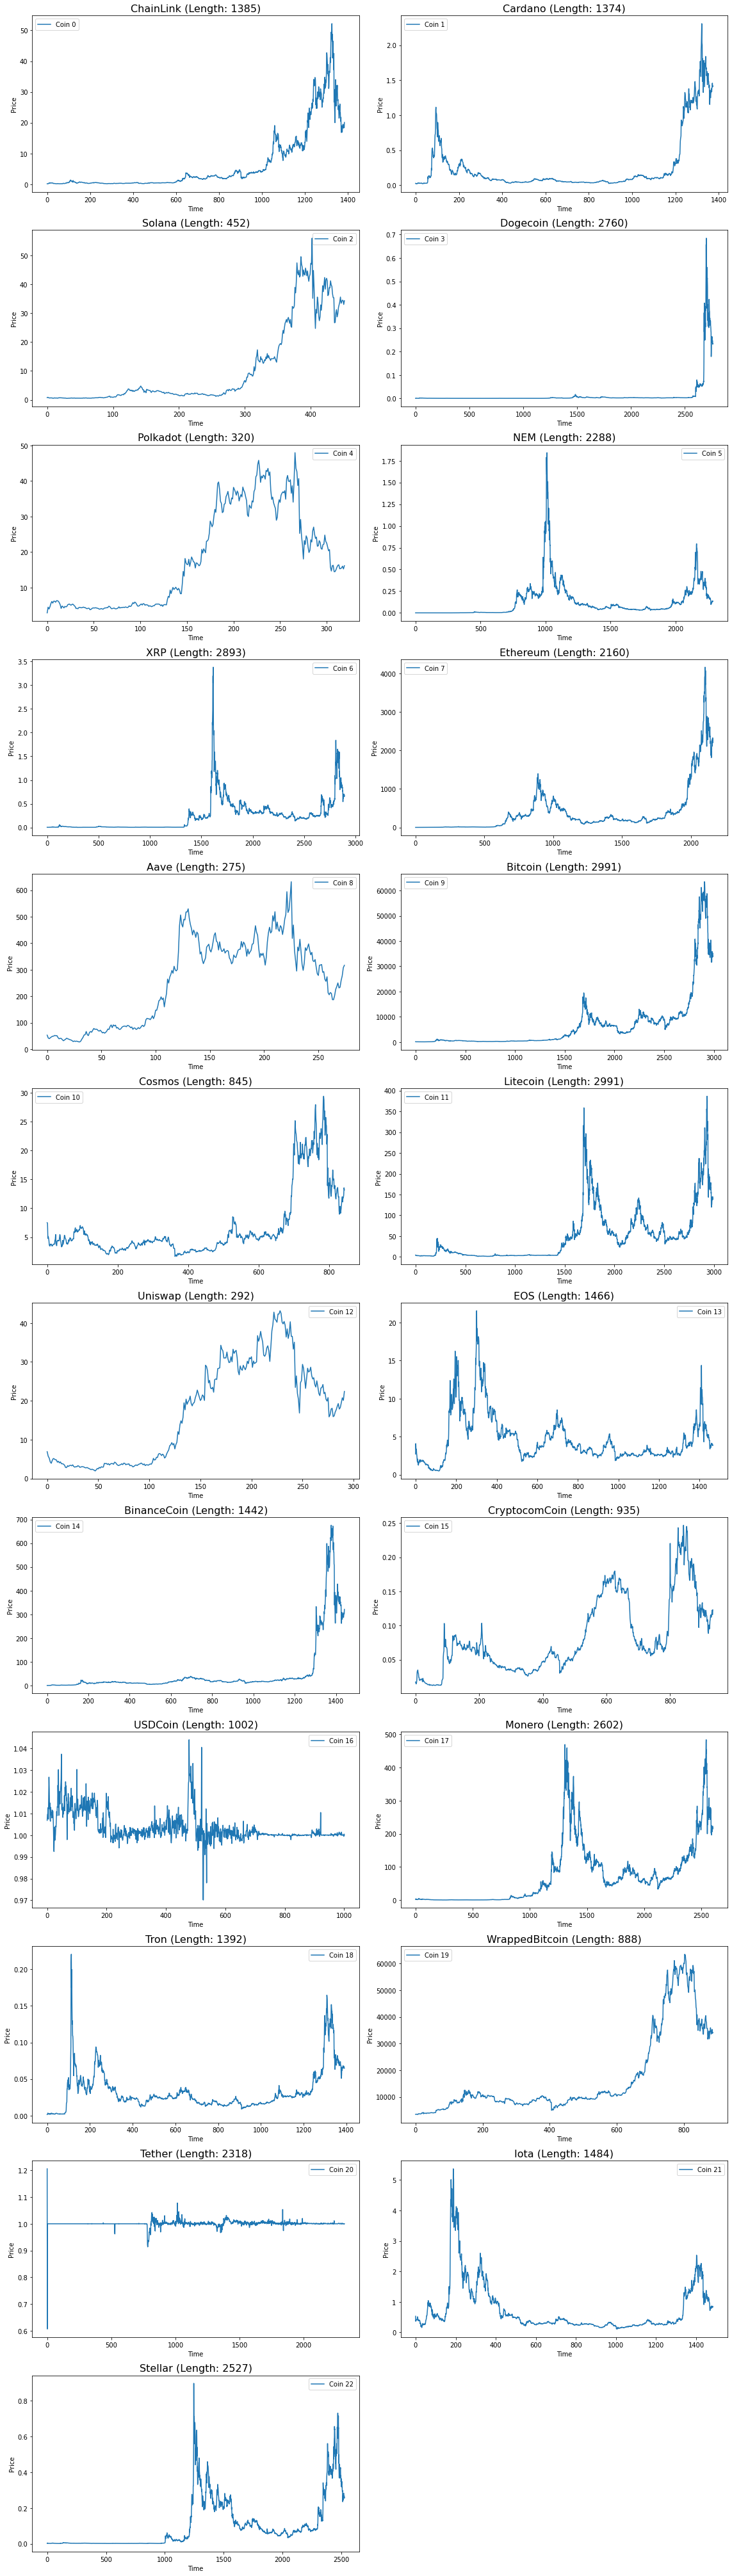

In [6]:
import math

coin_names = [i.split('_')[1].split('.')[0] for i in os.listdir('/kaggle/input/cryptocurrencypricehistory')]
print(coin_names)
# Calculate the number of rows and columns for subplots
num_coins = len(coin_names)
num_rows = 2
num_cols = math.ceil(num_coins / num_rows)

# Create subplots for the visualizations
fig, axs = plt.subplots(num_cols, num_rows, figsize=(16, 56))

# Flatten the axs array
axs = axs.flatten()

# Visualize data for each coin
for i in range(num_coins):
    ax = axs[i]  # Select the appropriate subplot
    
    coin_data = data[i]
    length = lengths[i]
    
    # Plot the time series data
    ax.plot(range(length), coin_data[:length], label='Coin {}'.format(i))
    
    # Set the title of the subplot with coin name and length
    ax.set_title('{} (Length: {})'.format(coin_names[i], lengths[i]), fontsize=16)
    
    # Set the x-axis label
    ax.set_xlabel('Time')
    
    # Set the y-axis label
    ax.set_ylabel('Price')
    
    # Display the legend
    ax.legend()

# Hide any extra subplots
for i in range(num_coins, num_rows * num_cols):
    axs[i].axis('off')

# Adjust the spacing between subplots
fig.tight_layout()

# Show the plot
plt.show()


## LSTM

In [7]:
# Function to scale the cryptocurrency data
def scale_data(data, lengths):
    coin_no = data.shape[0]  # Get the number of coins
    shift = np.zeros(coin_no)  # Initialize an array to store the shift values
    factor = np.zeros(coin_no)  # Initialize an array to store the scaling factors
    
    # Iterate through each coin
    for i in range(coin_no):
        max_val = data[i, :lengths[i]].max()  # Find the maximum value in the coin's data
        min_val = data[i, :lengths[i]].min()  # Find the minimum value in the coin's data
        shift[i] = min_val  # Store the minimum value as the shift
        factor[i] = max_val - min_val  # Calculate the scaling factor
        data[i, 0:lengths[i]] = (data[i, 0:lengths[i]] - shift[i]) / factor[i]  # Scale the coin's data
        
    return shift, factor

# Call the scale_data function to scale the data and retrieve the shift and factor
shift, factor = scale_data(data, lengths)

In [8]:
data.shape

(23, 2991)

In [9]:
# Function to create input-output sequences for training, validation, and testing
def create_sequences(data, lengths, start, end):
    x = []  # List to store input sequences
    y = []  # List to store output sequences
    
    for i in range(start, end):  # Iterate over the specified coins
        for j in range(History, lengths[i]):  # Iterate over the available data points for each coin
            x.append(data[i, j-History:j])  # Append the input sequence of historical data
            y.append(data[i, j])  # Append the corresponding output value
    
    return np.array(x)[:, :, np.newaxis], np.array(y)  # Convert the lists to numpy arrays and add a new axis

# Create input-output sequences for training
x_train, y_train = create_sequences(data, lengths, 0, 18)
print("Got", y_train.shape[0], "training sequences.")

# Create input-output sequences for validation
x_val, y_val = create_sequences(data, lengths, 18, 22)
print("Got", y_val.shape[0], "validation sequences.")

# Create input-output sequences for testing
x_test, y_test = create_sequences(data, lengths, 22, 23)
print("Got", y_test.shape[0], "test sequences.")


Got 27393 training sequences.
Got 5842 validation sequences.
Got 2467 test sequences.


In [10]:
def build_lstm ():
    # Build an LSTM model
    model = Sequential()
    model.add(LSTM(128, return_sequences=True, input_shape= (History, 1)))
    model.add(LSTM(64, return_sequences=False))
    model.add(Dense(25))
    model.add(Dense(1))
    
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanSquaredError()])
    model.summary()
    
    return model

model = build_lstm()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 60, 128)           66560     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense (Dense)                (None, 25)                1625      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 26        
Total params: 117,619
Trainable params: 117,619
Non-trainable params: 0
_________________________________________________________________


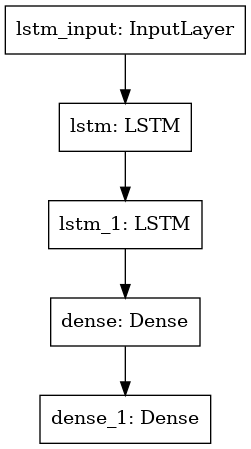

In [11]:
from keras.utils import plot_model

plot_model(model)

In [12]:
hist = model.fit(x_train, y_train, validation_data = (x_val, y_val), 
              batch_size=32, epochs=5) 

Epoch 1/5
857/857 [==============================] - 17s 10ms/step - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 4.3611e-04 - val_mean_squared_error: 4.3611e-04
Epoch 2/5
857/857 [==============================] - 7s 8ms/step - loss: 5.8506e-04 - mean_squared_error: 5.8506e-04 - val_loss: 3.6393e-04 - val_mean_squared_error: 3.6393e-04
Epoch 3/5
857/857 [==============================] - 7s 8ms/step - loss: 5.6471e-04 - mean_squared_error: 5.6471e-04 - val_loss: 4.1830e-04 - val_mean_squared_error: 4.1830e-04
Epoch 4/5
857/857 [==============================] - 7s 8ms/step - loss: 4.9624e-04 - mean_squared_error: 4.9624e-04 - val_loss: 3.3265e-04 - val_mean_squared_error: 3.3265e-04
Epoch 5/5
857/857 [==============================] - 7s 8ms/step - loss: 4.8503e-04 - mean_squared_error: 4.8503e-04 - val_loss: 3.4547e-04 - val_mean_squared_error: 3.4547e-04


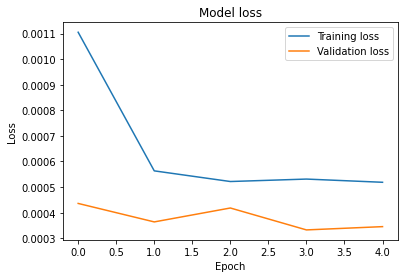

In [13]:
def show_stats (hist):
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title("Model loss")
    plt.ylabel("Loss")
    plt.xlabel("Epoch")
    plt.legend(["Training loss","Validation loss"])
    plt.show()

show_stats (hist)

Root mean square error on test data: 0.22621231086254634
Mean absolute error on test data: 0.15427308437451961
Durbin-Watson statistic: 0.006168523707829964
Mean absolute percentage error on test data: inf


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide


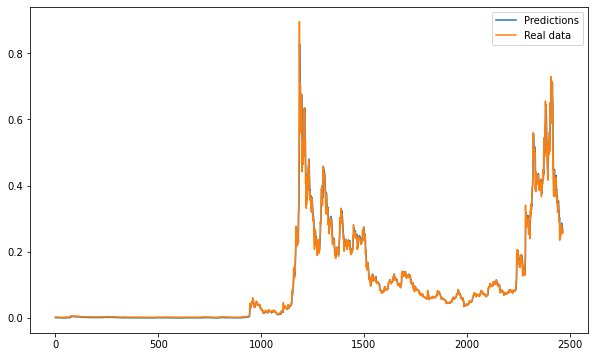

In [14]:
import numpy as np
import matplotlib.pyplot as plt

predictions = model.predict(x_test)

# Calculate RMSE
rmse = np.sqrt(np.mean(((predictions - y_test) ** 2)))
print("Root mean square error on test data:", rmse)

# Calculate MAE
mae = np.mean(np.abs(predictions - y_test))
print("Mean absolute error on test data:", mae)

# Calculate DW statistic
residuals = predictions - y_test
dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
print("Durbin-Watson statistic:", dw)

# Calculate MAPE
mape = np.mean(np.abs((predictions - y_test) / y_test)) * 100
print("Mean absolute percentage error on test data:", mape)

# Set the figure size
plt.figure(figsize=(10, 6))

plt.plot(predictions * factor[22] + shift[22])
plt.plot(y_test * factor[22] + shift[22])
plt.legend(["Predictions", "Real data"])
plt.show()


## ARIMA

In [15]:
!pip install pmdarima

     |████████████████████████████████| 1.8 MB 12.3 MB/s eta 0:00:01
     |████████████████████████████████| 9.9 MB 45.0 MB/s eta 0:00:01
     |████████████████████████████████| 15.7 MB 58.3 MB/s eta 0:00:01
     |████████████████████████████████| 233 kB 49.1 MB/s eta 0:00:01
     |████████████████████████████████| 48 kB 4.5 MB/s  eta 0:00:01
  Attempting uninstall: numpy
    Found existing installation: numpy 1.19.5
    Uninstalling numpy-1.19.5:
      Successfully uninstalled numpy-1.19.5
  Attempting uninstall: patsy
    Found existing installation: patsy 0.5.1
    Uninstalling patsy-0.5.1:
      Successfully uninstalled patsy-0.5.1
  Attempting uninstall: packaging
    Found existing installation: packaging 20.9
    Uninstalling packaging-20.9:
      Successfully uninstalled packaging-20.9
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.12.2
    Uninstalling statsmodels-0.12.2:
      Successfully uninstalled statsmodels-0.12.2
ERROR: pip's depende

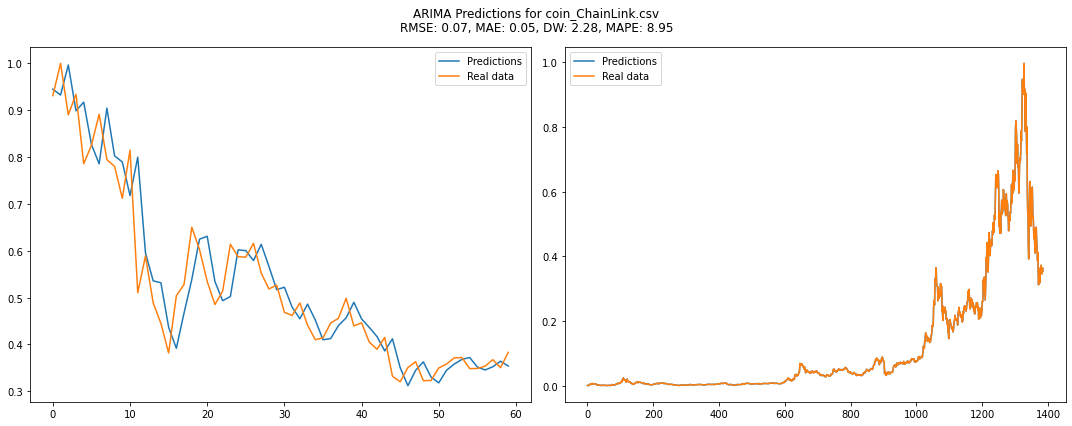

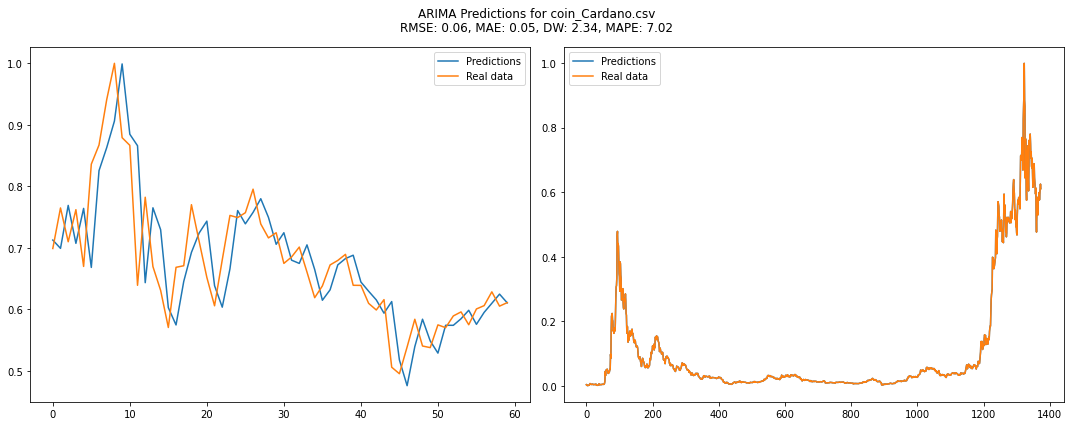

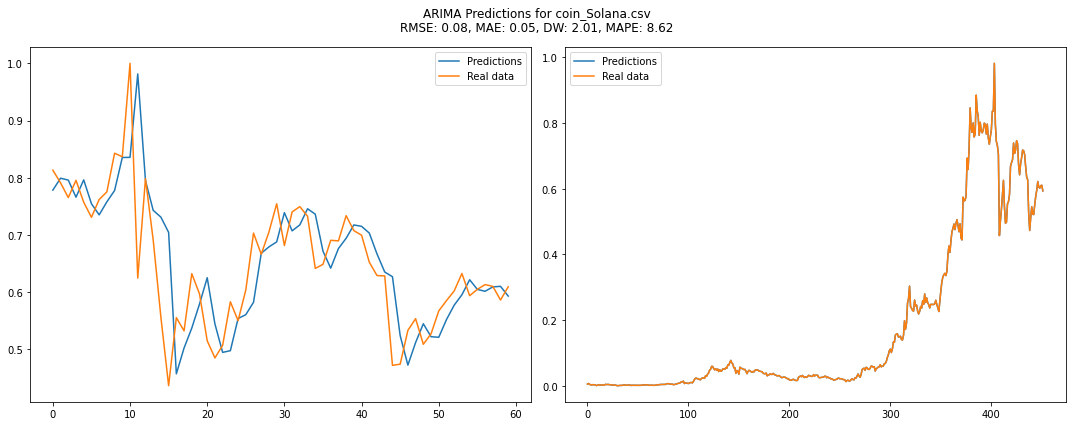

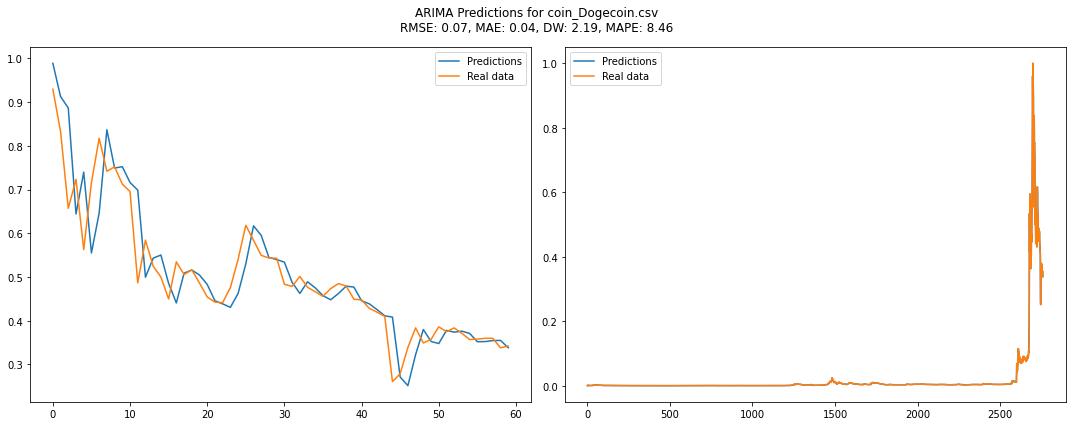

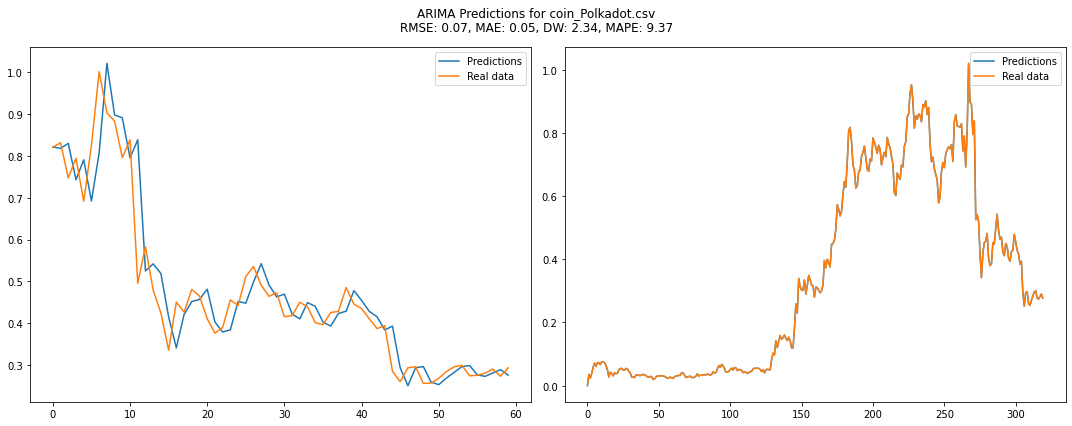

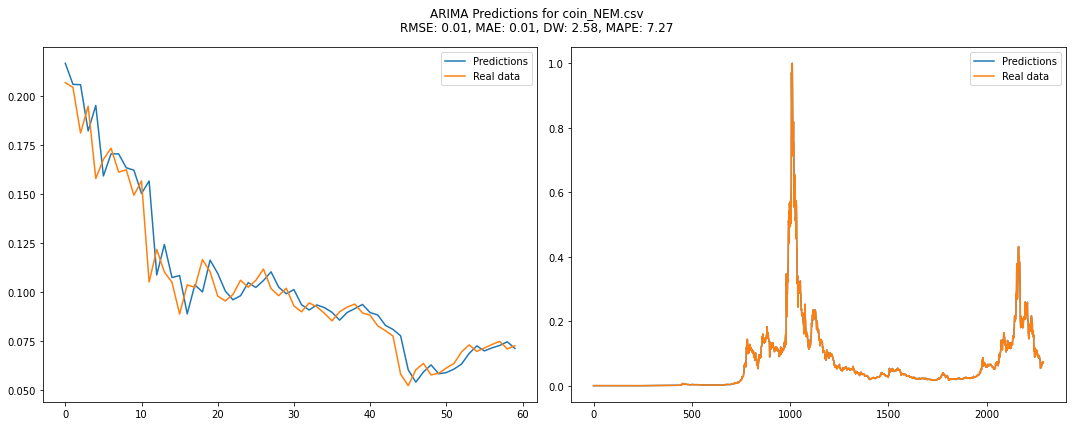

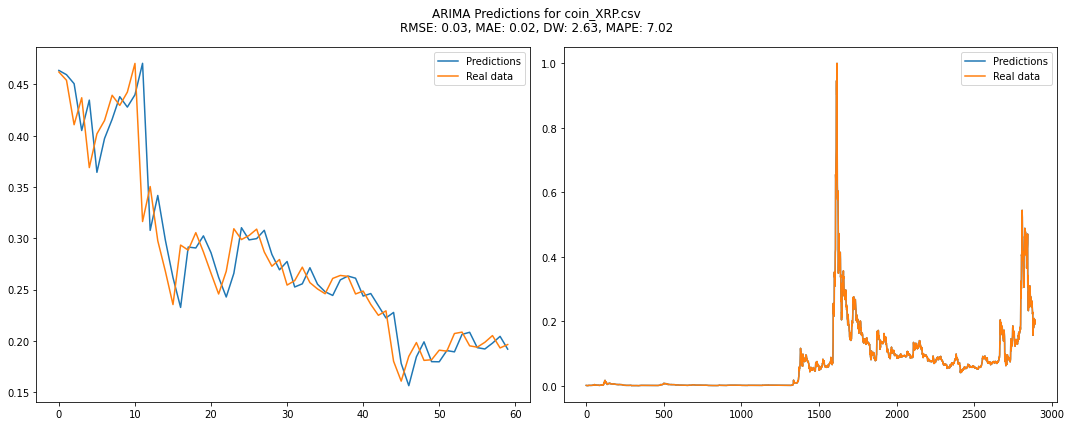

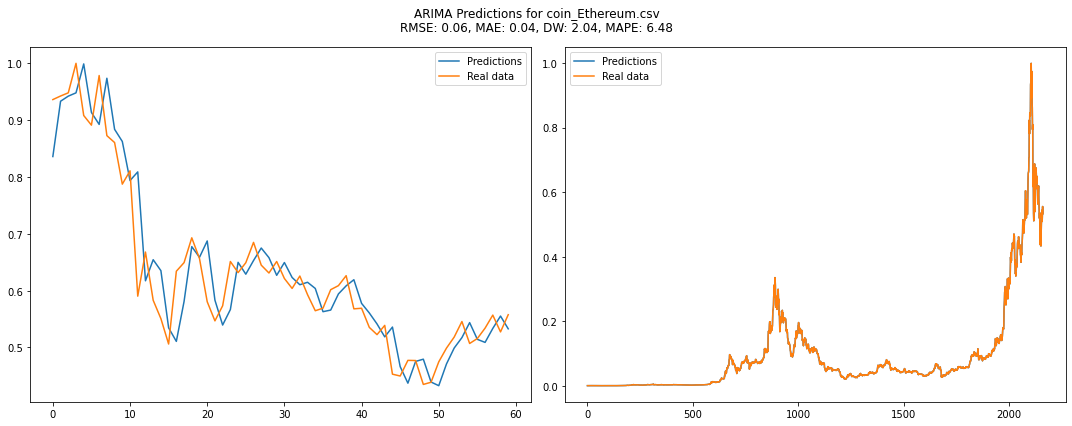

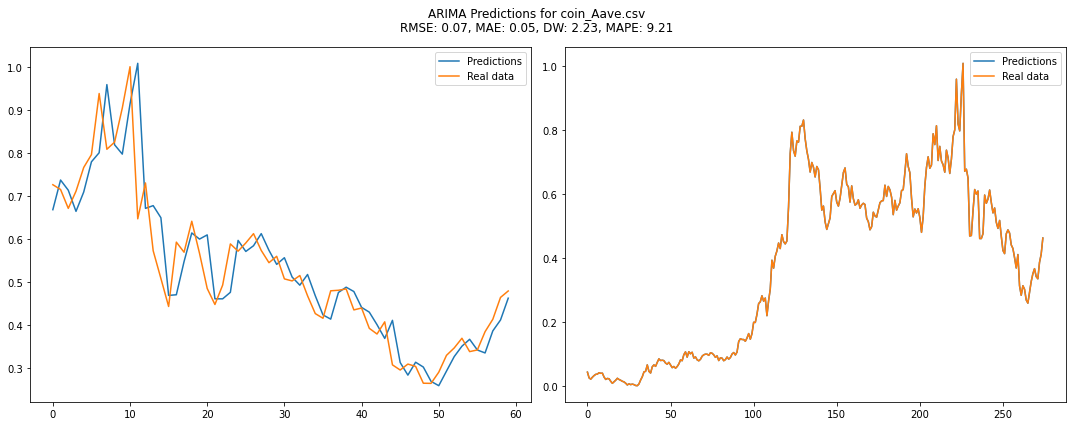

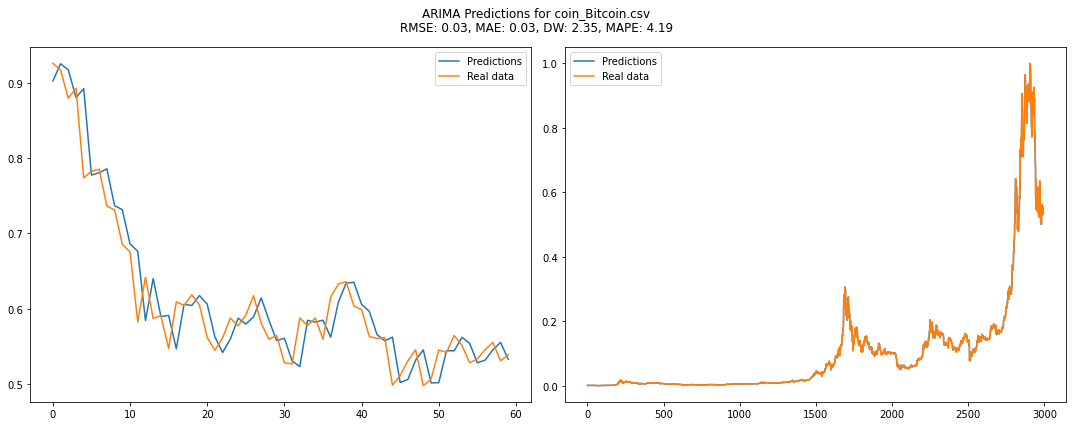

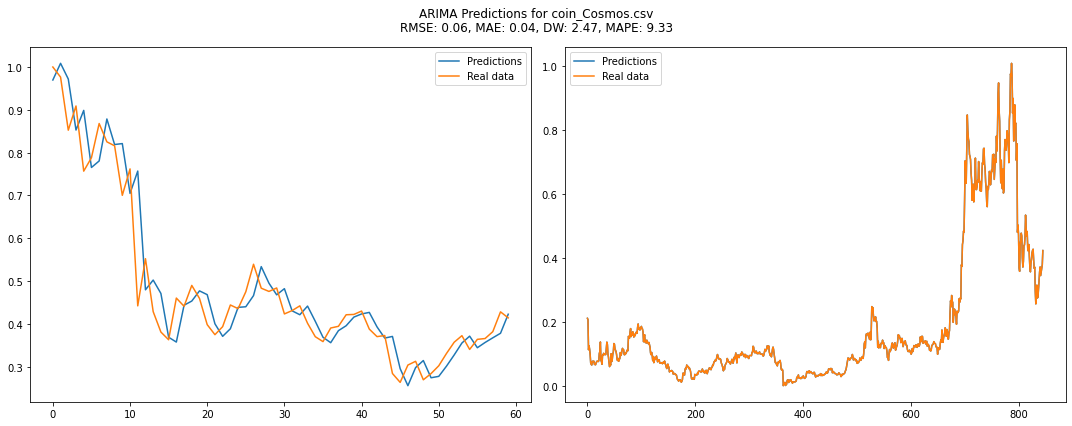

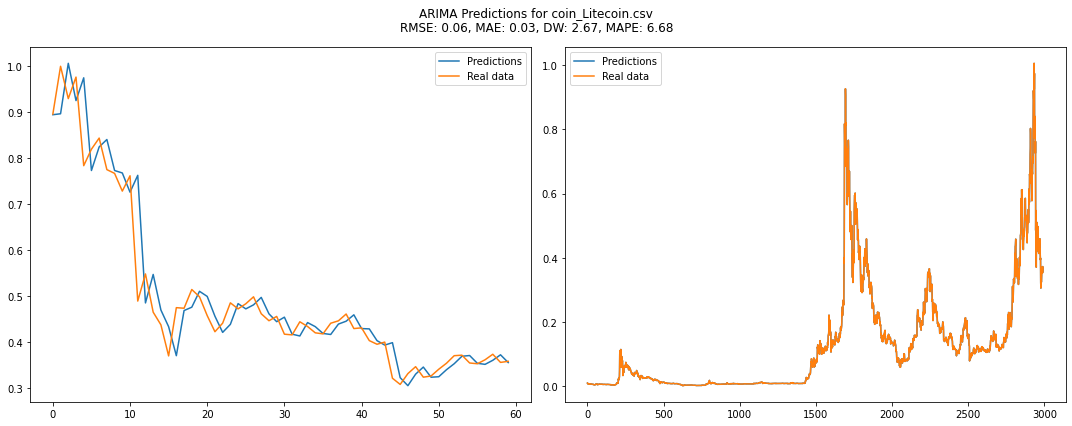

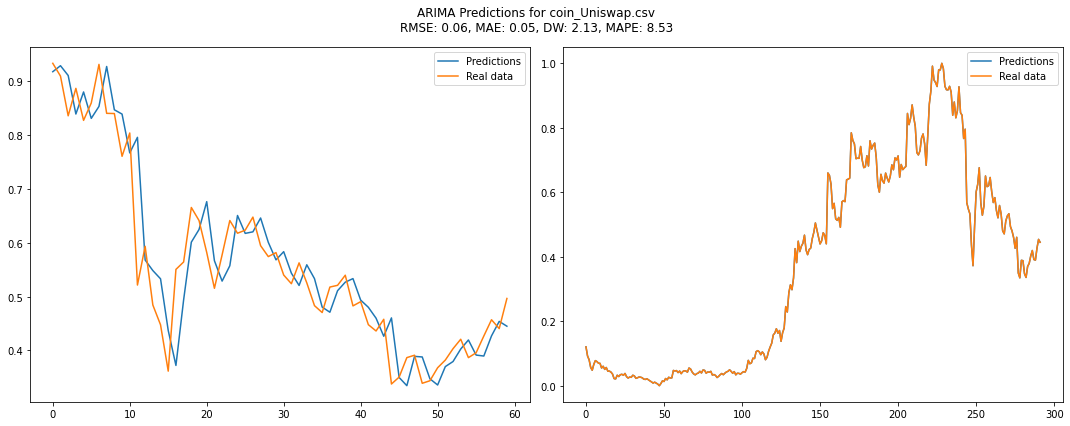

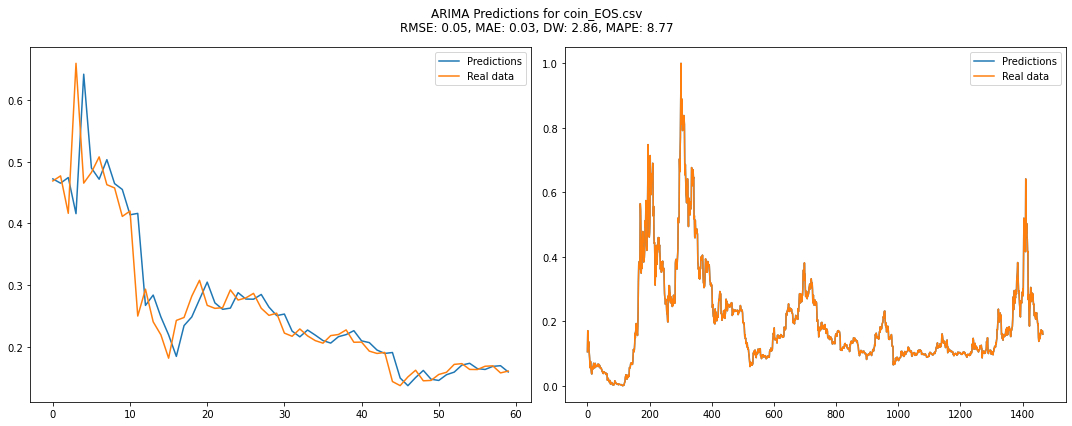

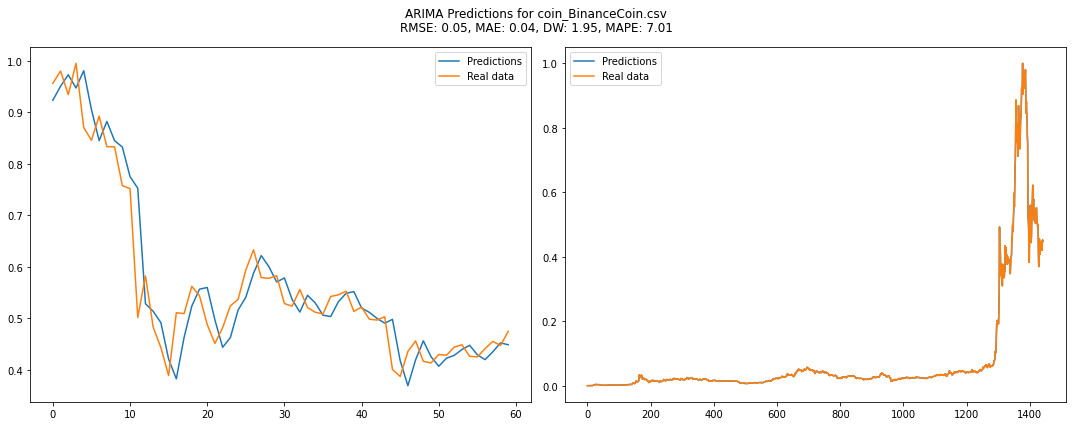

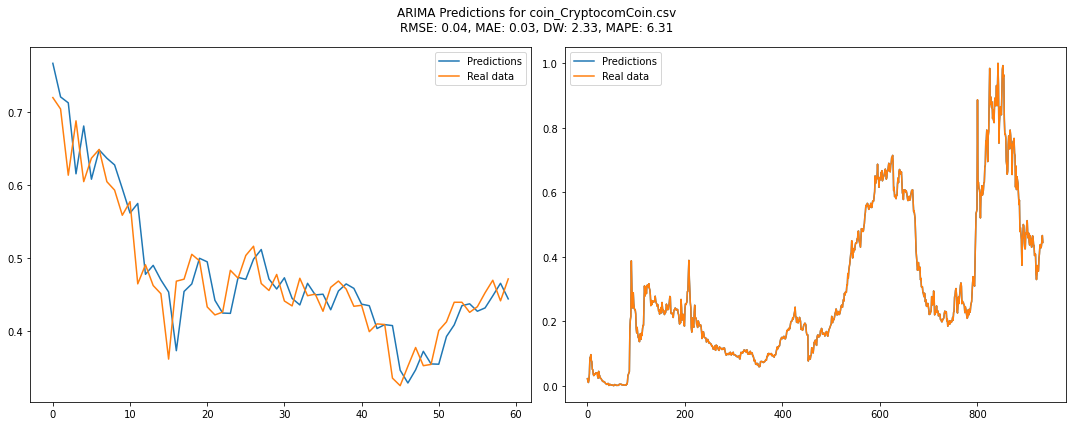

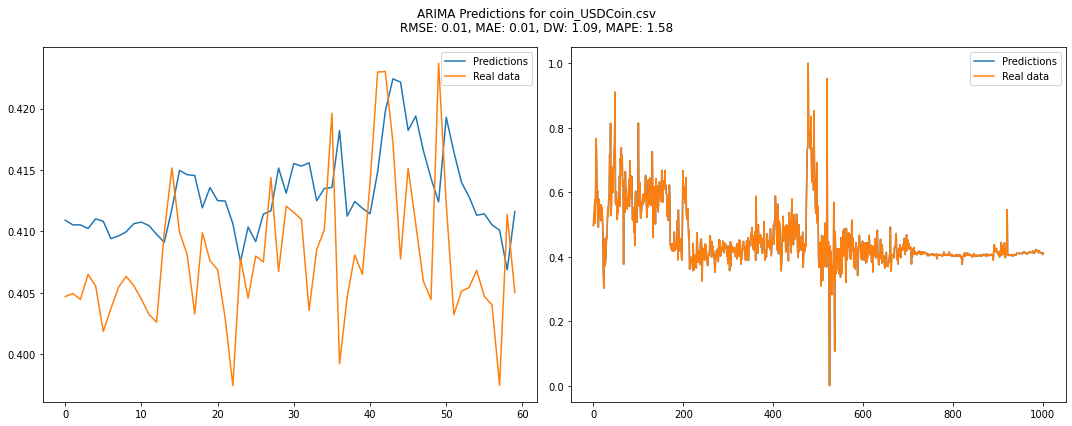

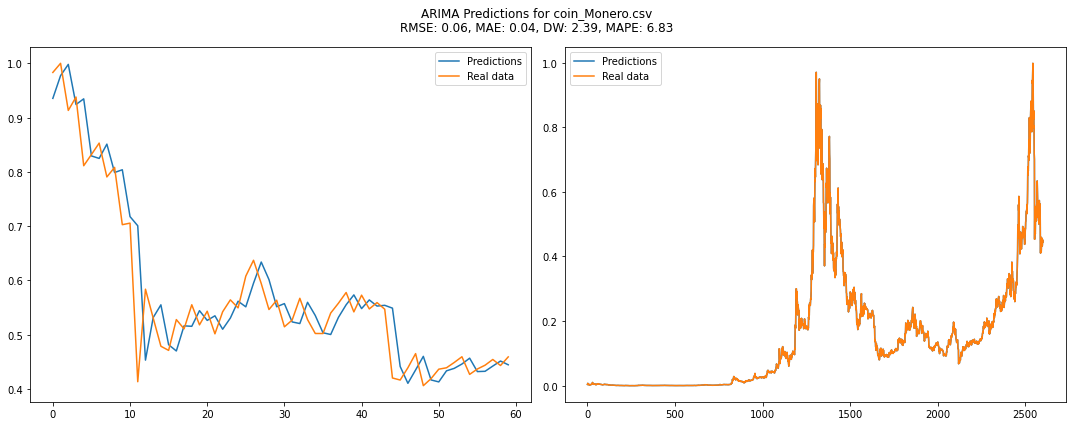

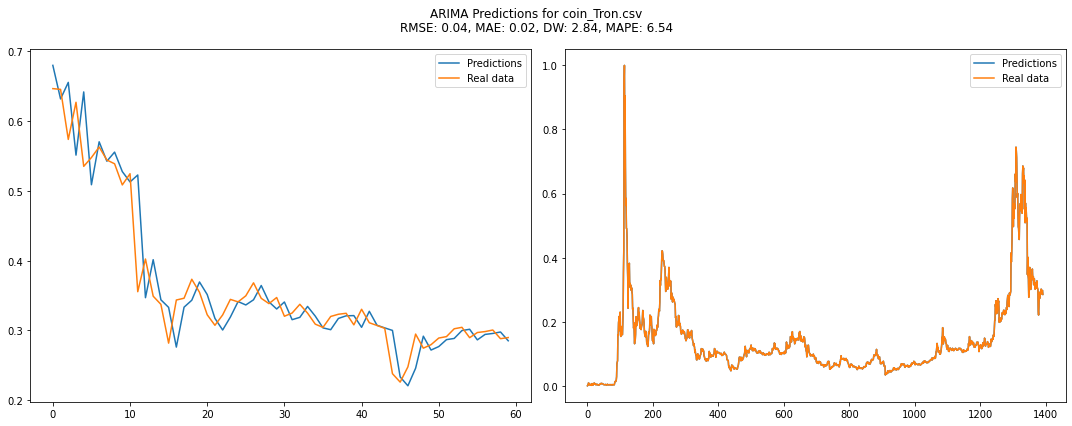

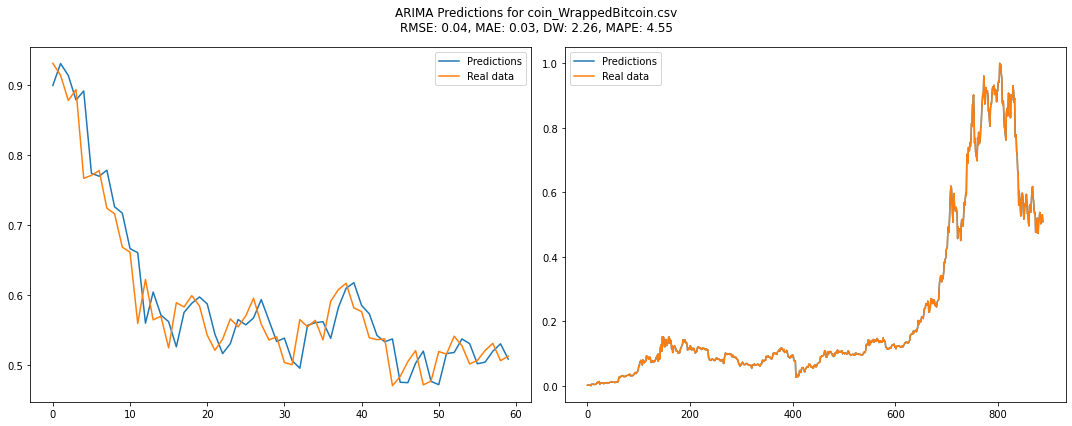

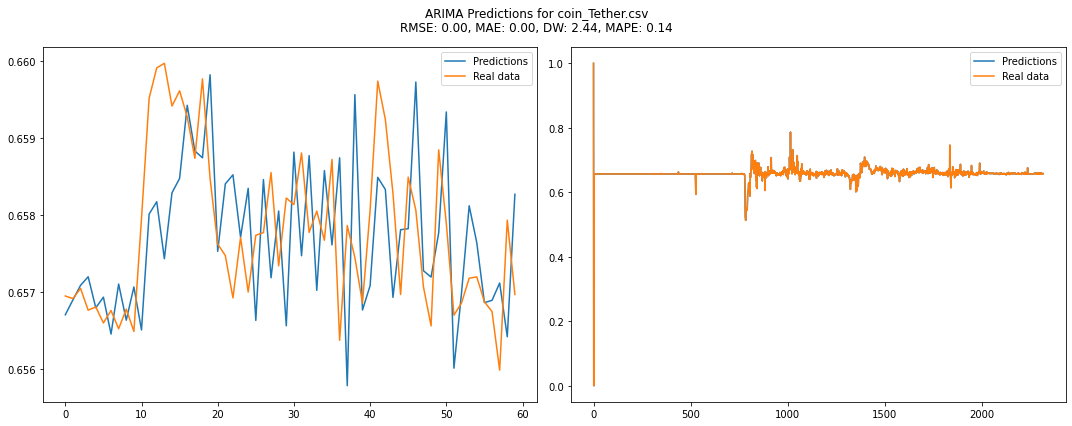

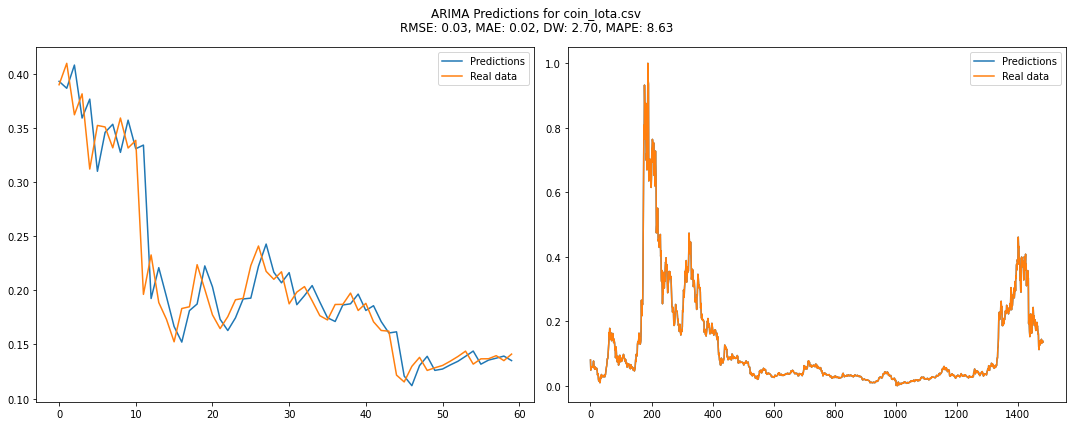

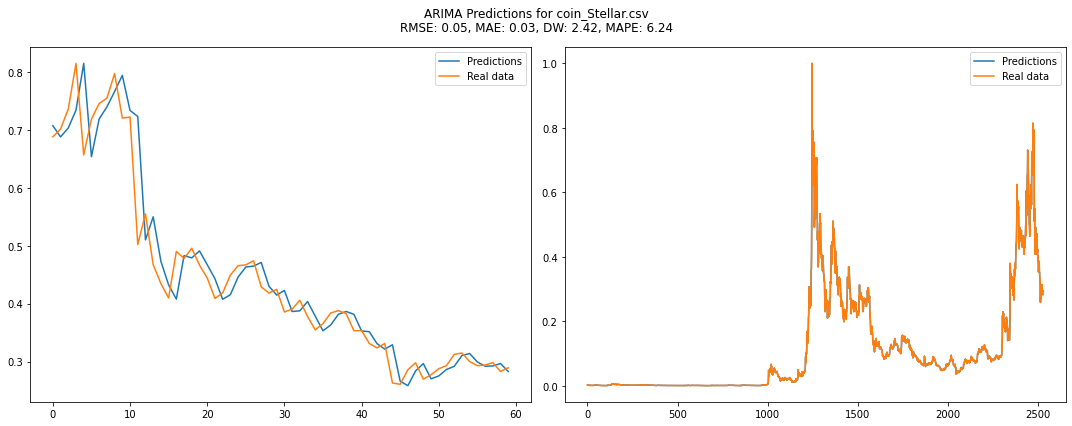

Mean Root Mean Squared Error: 0.0477402475906958
Mean Absolute Error: 0.031930277670082045
Mean Durbin-Watson statistic: 2.3277002271870684
Mean Absolute Percentage Error: 6.858021699498239


In [16]:
import os
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings

# Define the directory path of the cryptocurrency price data
data_dir = '/kaggle/input/cryptocurrencypricehistory'

# Get the list of filenames in the directory
filenames = os.listdir(data_dir)

# Create empty lists to store the metrics
rmse_list = []
mae_list = []
dw_list = []
mape_list = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Loop through each cryptocurrency dataset
    for filename in filenames:
        # Read the CSV file
        df = pd.read_csv(os.path.join(data_dir, filename))

        # Preprocess the dataframe
        scaler = MinMaxScaler()
        df['Close'] = scaler.fit_transform(df['Close'].values.reshape(-1, 1))
        
        arima_yhat = []
        for i in range(60):
            # Create ARIMA model
            arima_model = ARIMA(df['Close'][:-60+i], order=(3, 0, 1))

            # Fit the ARIMA model
            arima_model_fit = arima_model.fit()

            # Forecast using ARIMA
            arima_forecast = arima_model_fit.forecast(steps=1)
            arima_yhat.append(arima_forecast.values[0])

        # Scale back the predictions and test data
        arima_yhat = arima_yhat
        real_data = df['Close'][-60:].values

        # Calculate RMSE
        rmse = np.sqrt(np.mean(((arima_yhat - real_data) ** 2)))
        rmse_list.append(rmse)

        # Calculate MAE
        mae = np.mean(np.abs(arima_yhat - real_data))
        mae_list.append(mae)

        # Calculate DW statistic
        residuals = arima_yhat - real_data
        dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
        dw_list.append(dw)

        # Calculate MAPE
        mape = np.mean(np.abs((arima_yhat - real_data) / real_data)) * 100
        mape_list.append(mape)

        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
        fig.suptitle(f'ARIMA Predictions for {filename}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, DW: {dw:.2f}, MAPE: {mape:.2f}')

        # Plot predictions and real data for the last 18 days in the first subplot
        axes[0].plot(arima_yhat)
        axes[0].plot(real_data)
        axes[0].legend(["Predictions", "Real data"])

        preds = df['Close'].values
        preds[-60:] = arima_yhat
        # Plot predictions and real data for the entire data range in the second subplot
        axes[1].plot(preds)
        axes[1].plot(df['Close'])
        axes[1].legend(["Predictions", "Real data"])

        # Adjust the layout
        plt.tight_layout()

        # Show the plots
        plt.show()

# Calculate the mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_dw = np.mean(dw_list)
mean_mape = np.mean(mape_list)

# Print the mean metrics
print("Mean Root Mean Squared Error:", mean_rmse)
print("Mean Absolute Error:", mean_mae)
print("Mean Durbin-Watson statistic:", mean_dw)
print("Mean Absolute Percentage Error:", mean_mape)


## Prophet

In [17]:
!pip install prophet

     |████████████████████████████████| 13.0 MB 15.2 MB/s eta 0:00:01
     |████████████████████████████████| 83 kB 1.6 MB/s  eta 0:00:01
     |████████████████████████████████| 541 kB 57.4 MB/s eta 0:00:01
  Attempting uninstall: holidays
    Found existing installation: holidays 0.11.1
    Uninstalling holidays-0.11.1:
      Successfully uninstalled holidays-0.11.1
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 1.1.0 which is incompatible.


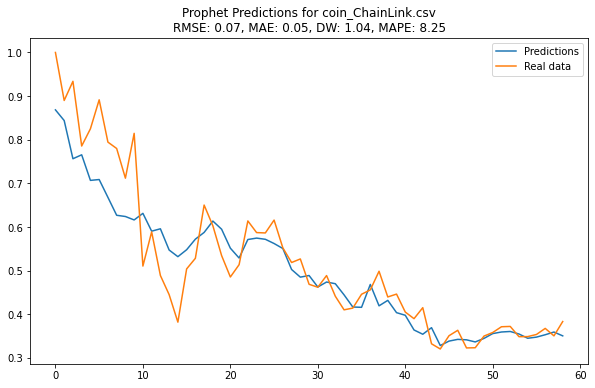

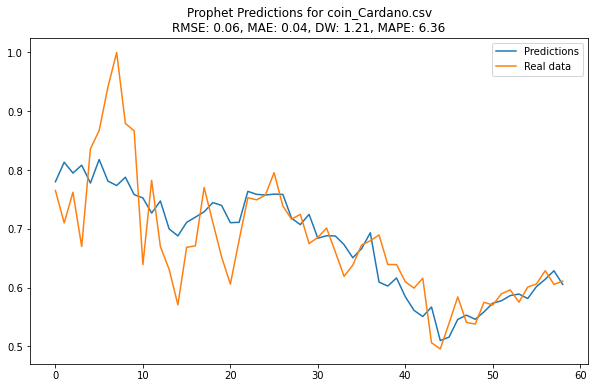

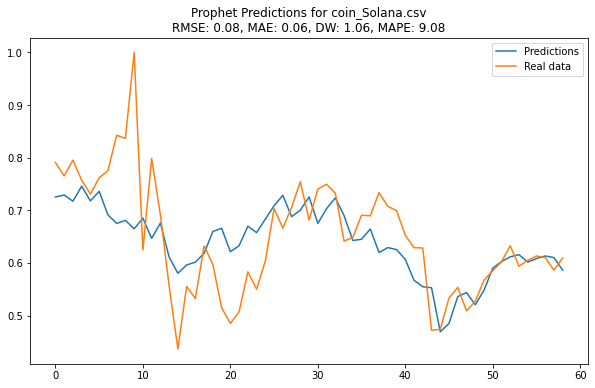

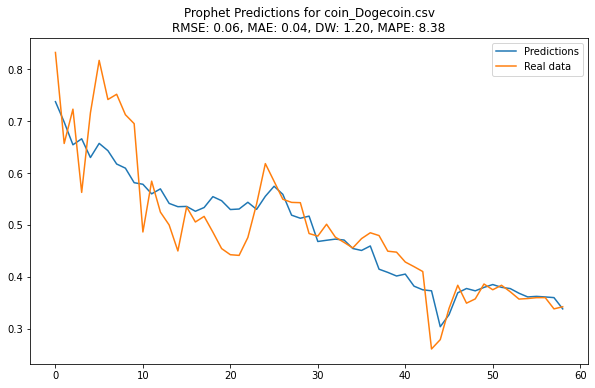

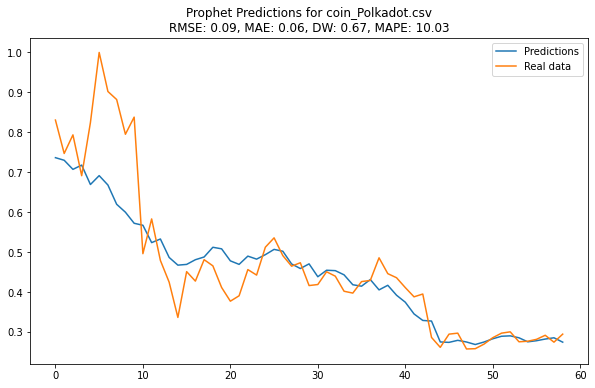

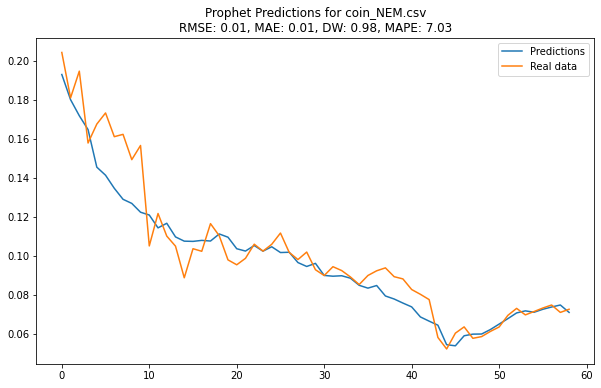

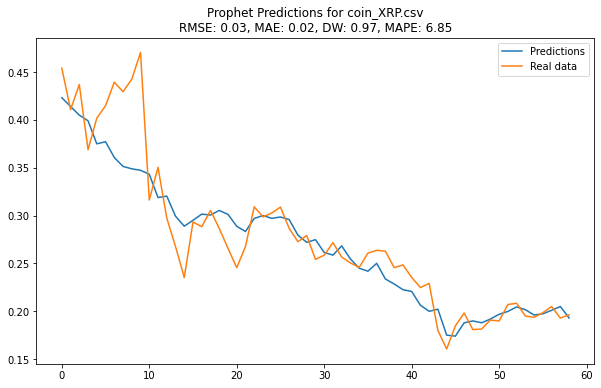

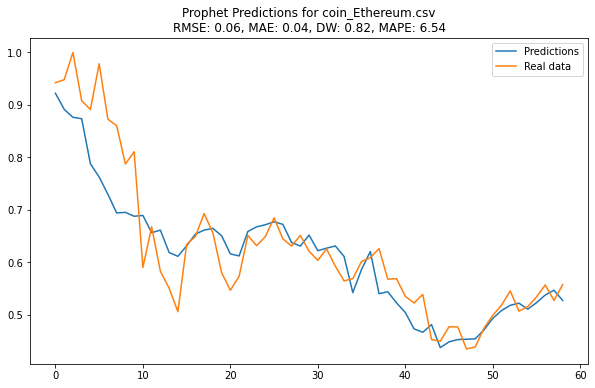

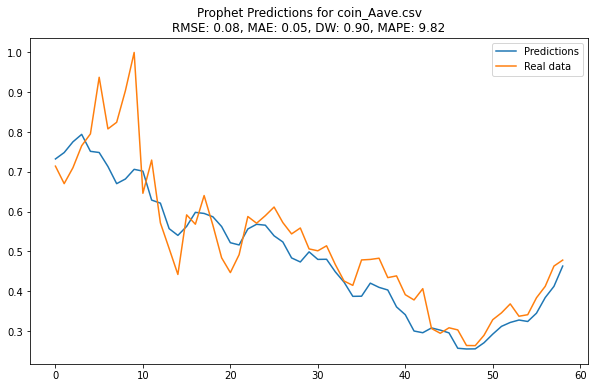

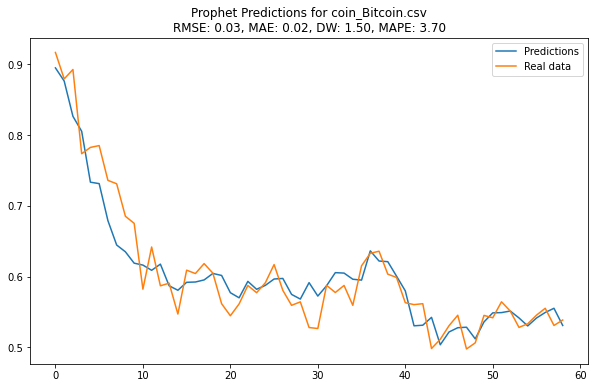

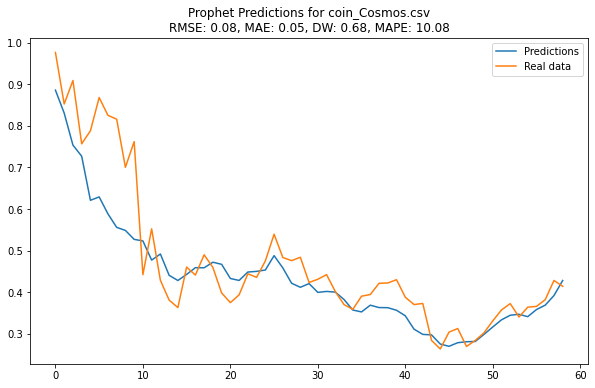

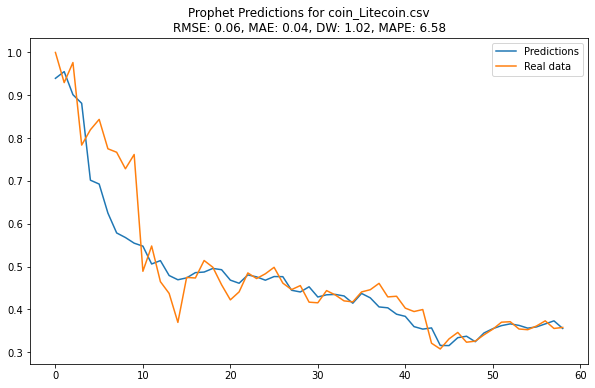

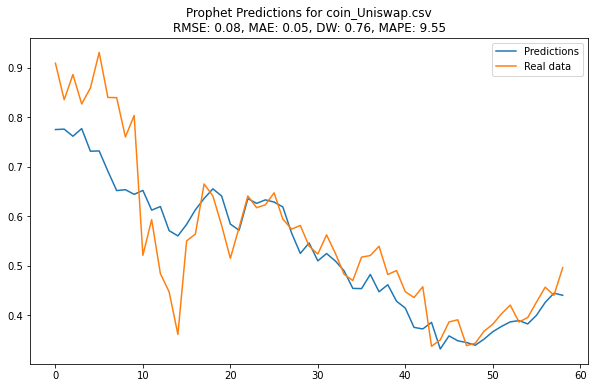

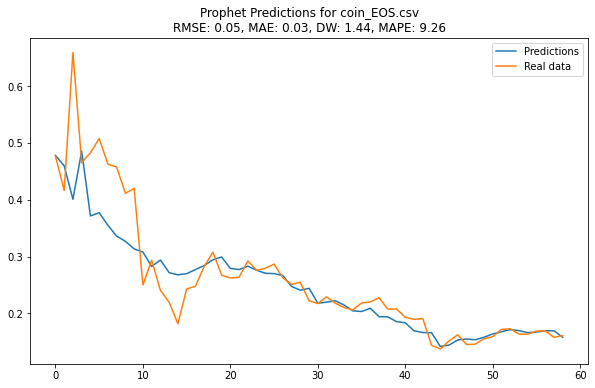

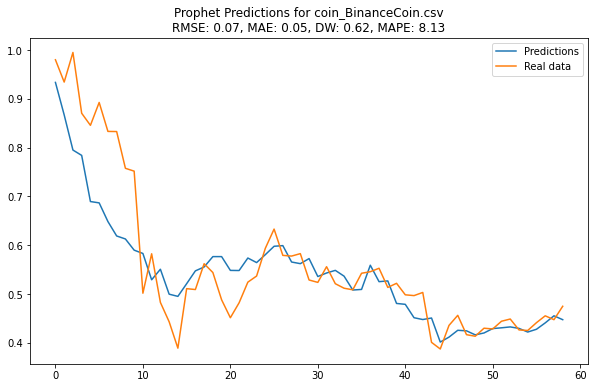

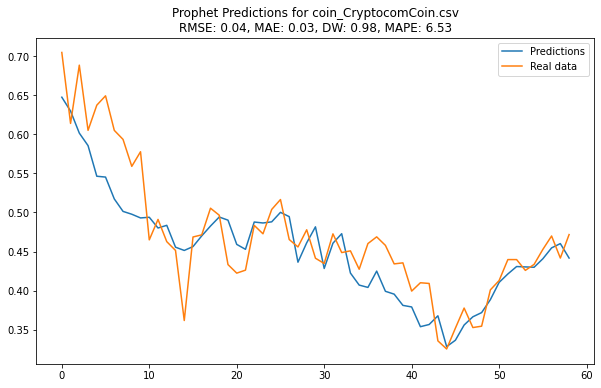

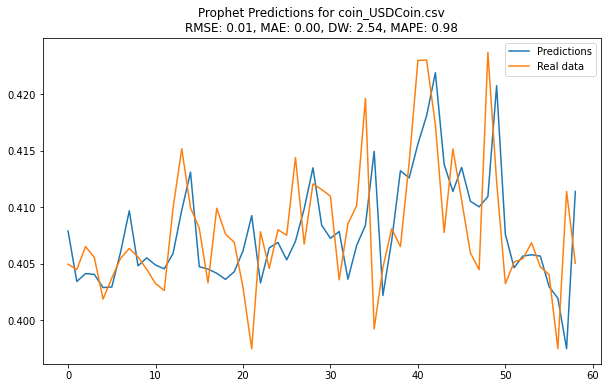

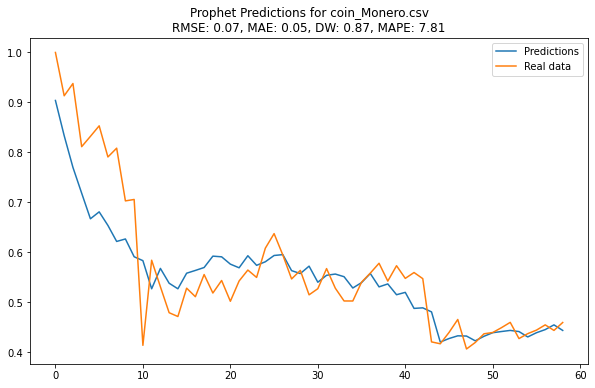

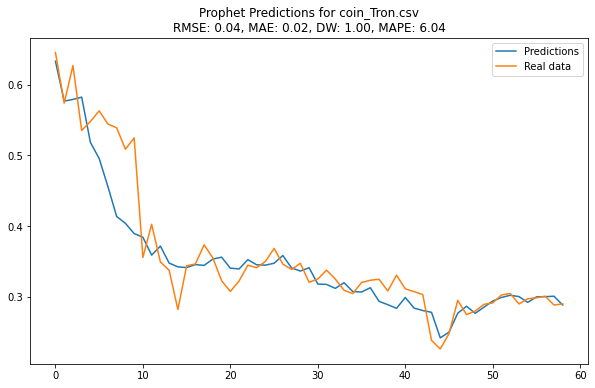

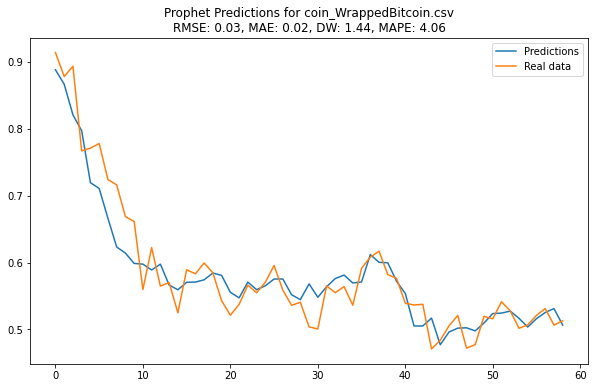

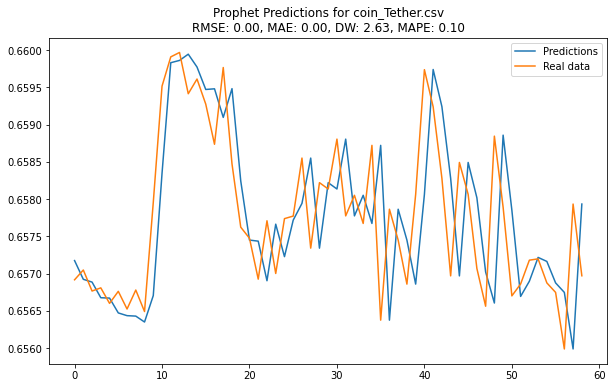

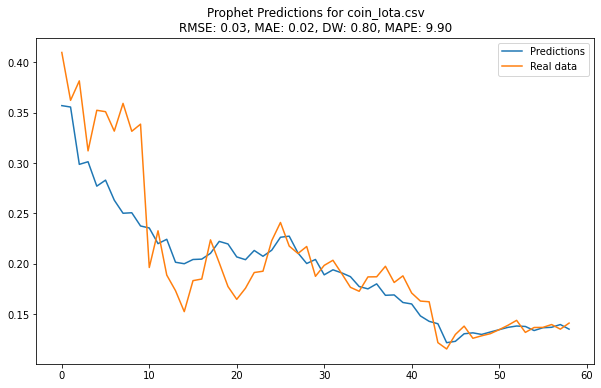

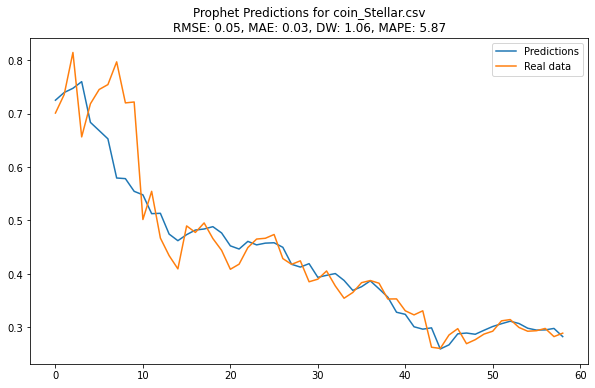

Mean Root Mean Squared Error: 0.05179739590961854
Mean Absolute Error: 0.03520567512610602
Mean Durbin-Watson statistic: 1.138905895540988
Mean Absolute Percentage Error: 6.996922803142412


In [18]:
import os
import pandas as pd
import numpy as np
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging

# Define the directory path of the cryptocurrency price data
data_dir = '/kaggle/input/cryptocurrencypricehistory'

# Get the list of filenames in the directory
filenames = os.listdir(data_dir)

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

# Create empty lists to store the metrics
rmse_list = []
mae_list = []
dw_list = []
mape_list = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    
    # Loop through each cryptocurrency dataset
    for filename in filenames:
        # Read the CSV file
        df = pd.read_csv(os.path.join(data_dir, filename))

        # Preprocess the dataframe
        df = df.rename(columns={"Date": "ds", "Close": "y"})

        # Preprocess the dataframe
        scaler = MinMaxScaler()
        df['y'] = scaler.fit_transform(df['y'].values.reshape(-1, 1))
        
        prophet_yhat = []
        for i in range(59):
            # Create a new Prophet model
            model = Prophet()

            # Fit the model with the data
            model.fit(df[-60+i:])

            # Forecast using Prophet
            future = model.make_future_dataframe(periods=1, freq='D')
            forecast = model.predict(future)
            yhat = forecast['yhat'].values[0]

            # Scale back the predictions and true values
            real_data = df['y'].values[-60+i:]
            prophet_yhat.append(yhat)
            
        # Scale back the predictions and test data
        real_data = df['y'][-59:].values

        # Calculate RMSE
        rmse = np.sqrt(np.mean(((prophet_yhat - real_data) ** 2)))
        rmse_list.append(rmse)

        # Calculate MAE
        mae = np.mean(np.abs(prophet_yhat - real_data))
        mae_list.append(mae)

        # Calculate DW statistic
        residuals = prophet_yhat - real_data
        dw = np.sum(np.diff(residuals)**2) / np.sum(residuals**2)
        dw_list.append(dw)

        # Calculate MAPE
        mape = np.mean(np.abs((prophet_yhat - real_data) / real_data)) * 100
        mape_list.append(mape)

        # Set the figure size and title
        plt.figure(figsize=(10, 6))
        plt.title(f'Prophet Predictions for {filename}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, DW: {dw:.2f}, MAPE: {mape:.2f}')

        # Plot predictions and true values
        plt.plot(prophet_yhat)
        plt.plot(real_data)
        plt.legend(["Predictions", "Real data"])

        # Show the plot
        plt.show()

# Calculate the mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_dw = np.mean(dw_list)
mean_mape = np.mean(mape_list)

# Print the mean metrics
print("Mean Root Mean Squared Error:", mean_rmse)
print("Mean Absolute Error:", mean_mae)
print("Mean Durbin-Watson statistic:", mean_dw)
print("Mean Absolute Percentage Error:", mean_mape)


In [19]:
df.shape[0]-1

2526

## ExponentialSmoothing

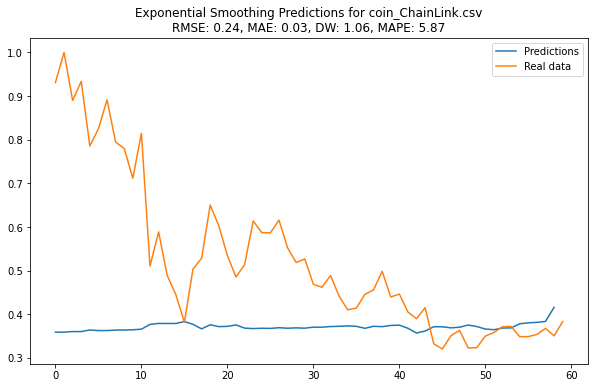

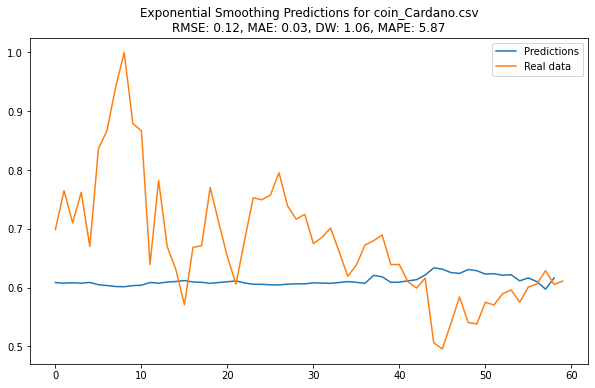

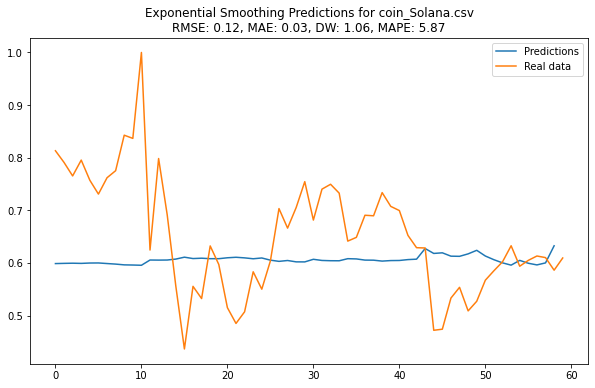

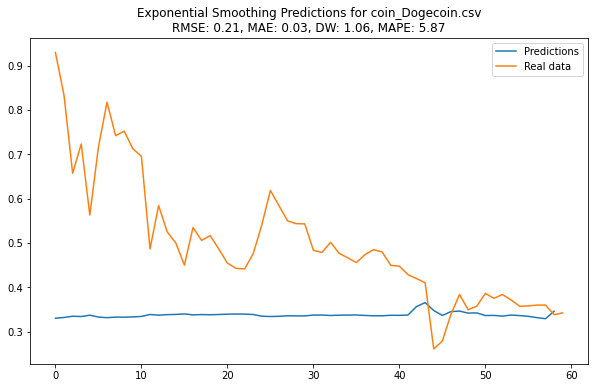

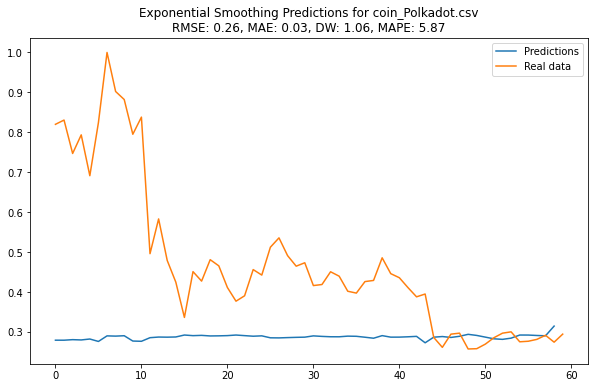

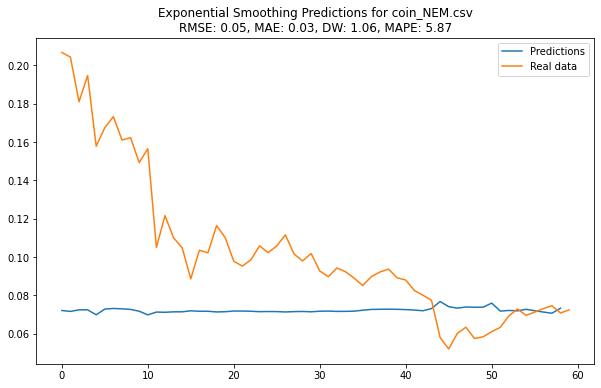

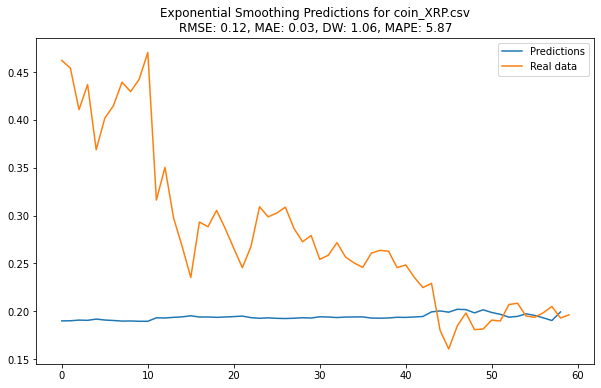

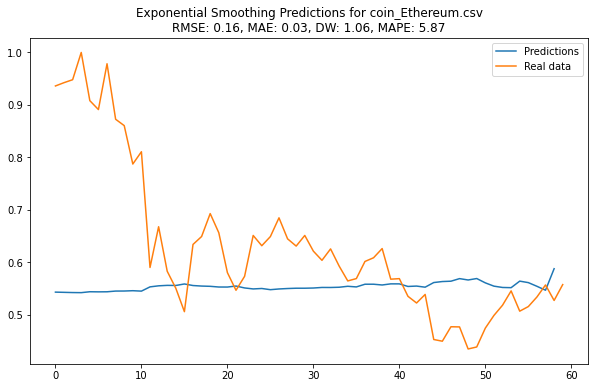

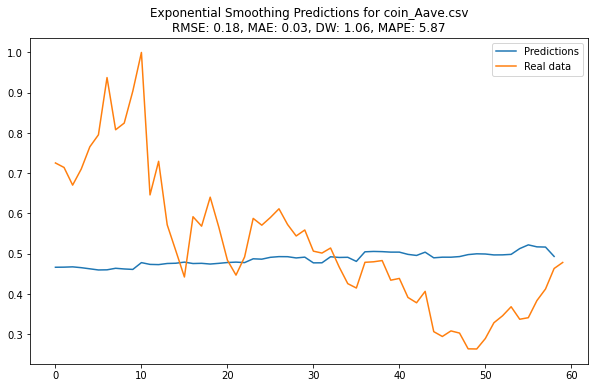

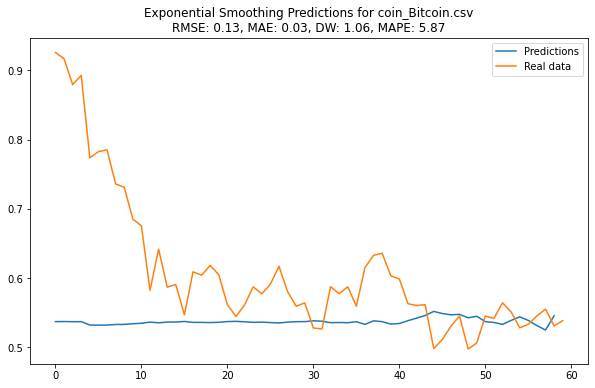

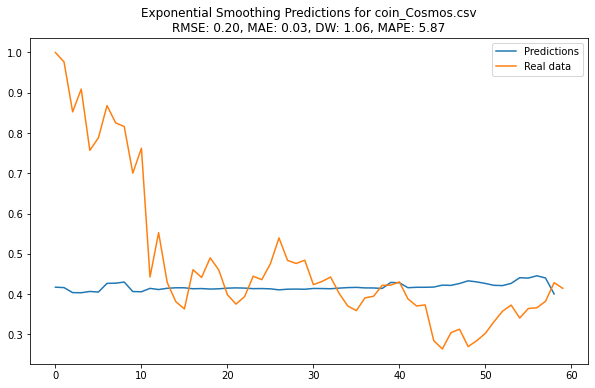

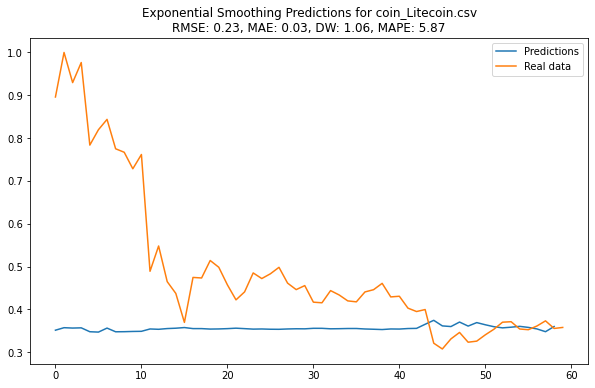

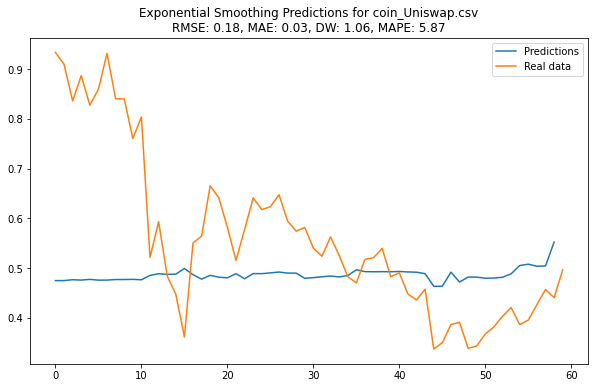

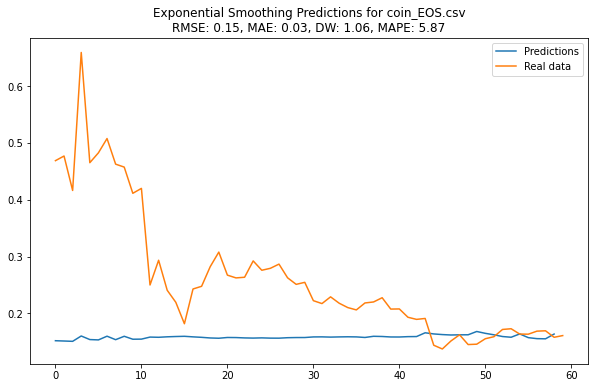

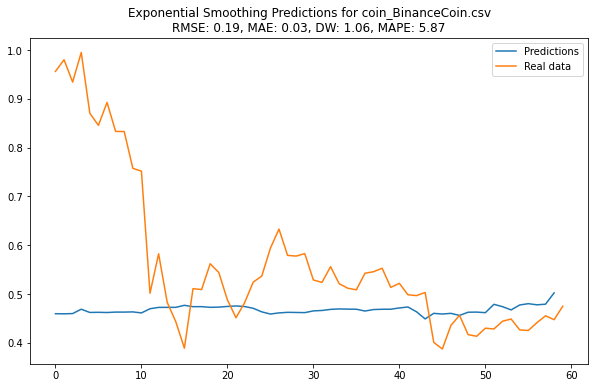

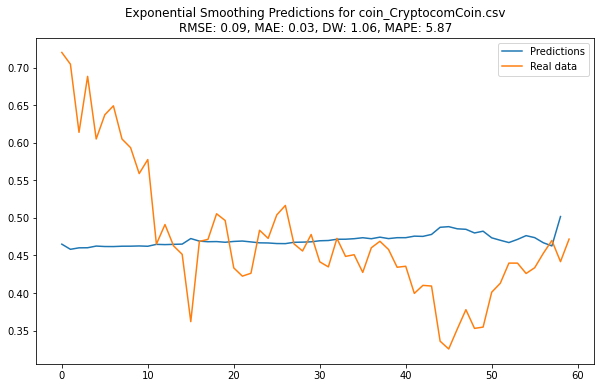

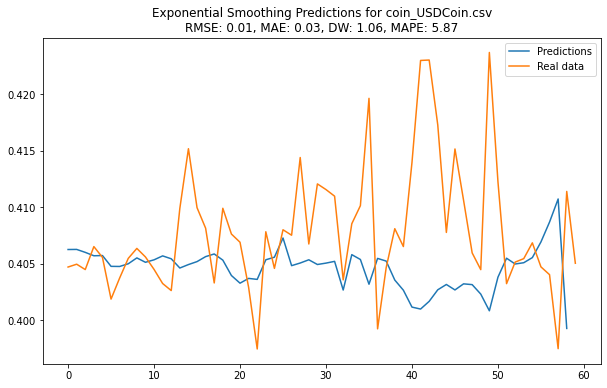

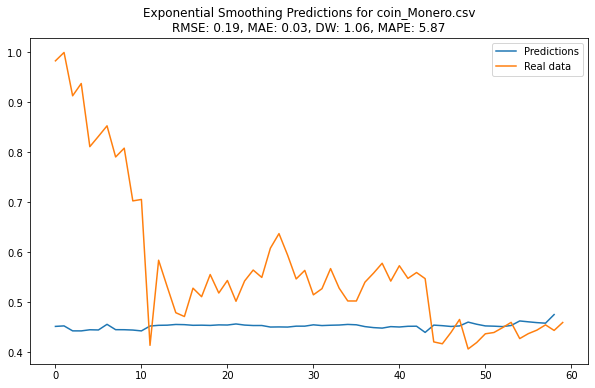

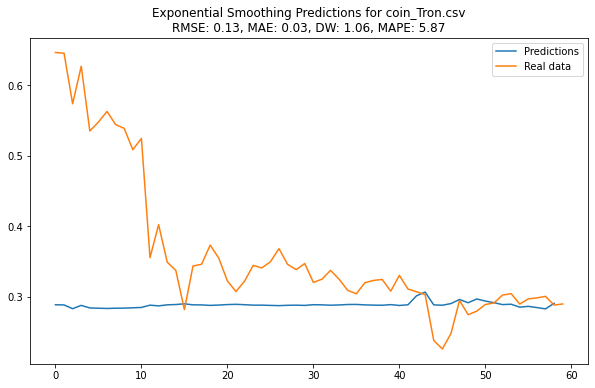

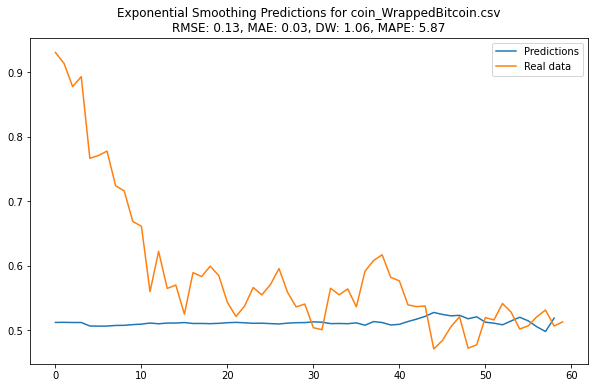

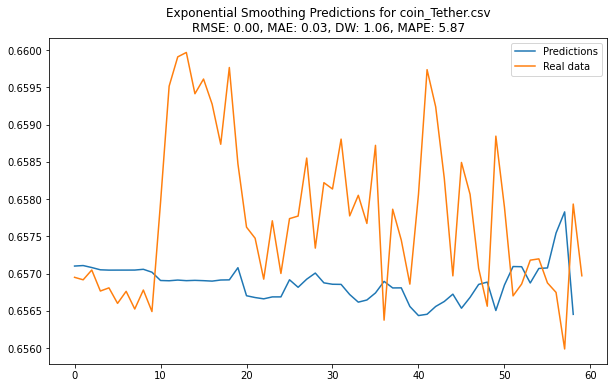

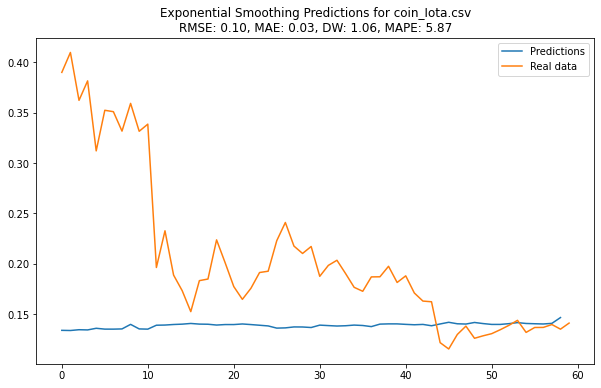

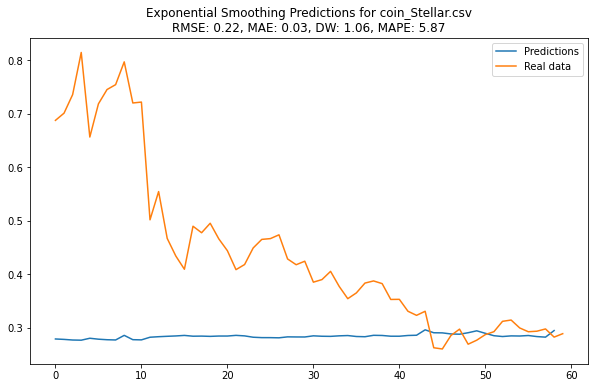

Mean Root Mean Squared Error: 0.14790534199895566


In [20]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the directory path of the cryptocurrency price data
data_dir = '/kaggle/input/cryptocurrencypricehistory'

# Get the list of filenames in the directory
filenames = os.listdir(data_dir)

# Disable logging output from Prophet and cmdstanpy
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

# Create an empty list to store the RMSE for each model
rmse_list = []
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    # Loop through each cryptocurrency dataset
    for filename in filenames:
        # Read the CSV file
        df = pd.read_csv(os.path.join(data_dir, filename))

        # Preprocess the dataframe
        df = df.rename(columns={"Date": "ds", "Close": "y"})

        # Preprocess the dataframe
        scaler = MinMaxScaler()
        df['y'] = scaler.fit_transform(df['y'].values.reshape(-1, 1))

        # Perform exponential smoothing
        prophet_yhat = []
        for i in range(59):
#             print(df['y'][-60 + i:])
#             print(i)
            # Create a new Exponential Smoothing model
            model = ExponentialSmoothing(df['y'][-60 + i:], trend='add')

            # Fit the model with the data
            model_fit = model.fit()

            # Forecast using Exponential Smoothing
            yhat = model_fit.forecast(steps=1)

            # Scale back the prediction
            prophet_yhat.append(yhat)

        # Scale back the predictions and true values
        real_data = df['y'].values[-60:]
        prophet_yhat = np.array(prophet_yhat)

        # Calculate RMSE
        rmse = np.sqrt(np.mean(((prophet_yhat - real_data) ** 2)))
        rmse_list.append(rmse)

        # Set the figure size and title
        plt.figure(figsize=(10, 6))
        plt.title(f'Exponential Smoothing Predictions for {filename}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, DW: {dw:.2f}, MAPE: {mape:.2f}')

        # Plot predictions and true values
        plt.plot(prophet_yhat)
        plt.plot(real_data)
        plt.legend(["Predictions", "Real data"])

        # Show the plot
        plt.show()

    # Calculate the mean RMSE
    mean_rmse = np.mean(rmse_list)
    print("Mean Root Mean Squared Error:", mean_rmse)


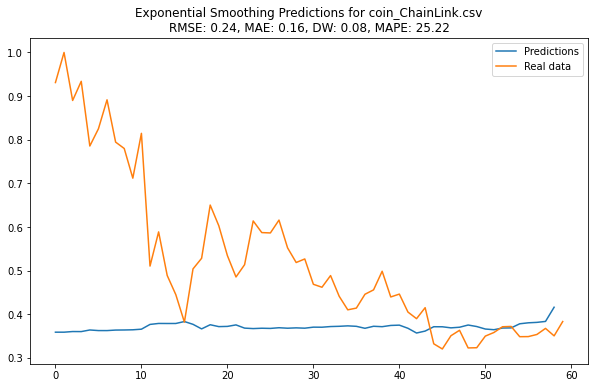

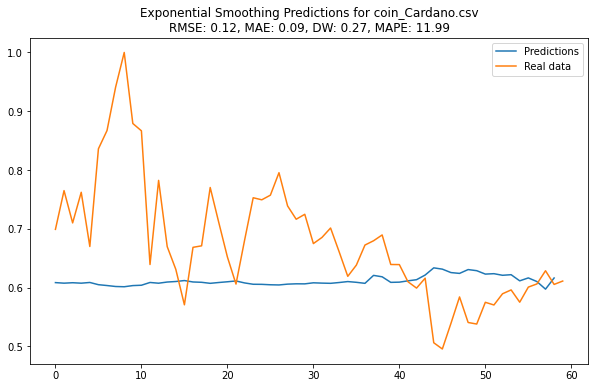

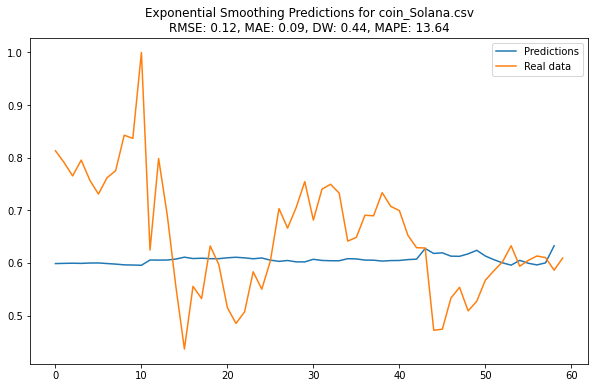

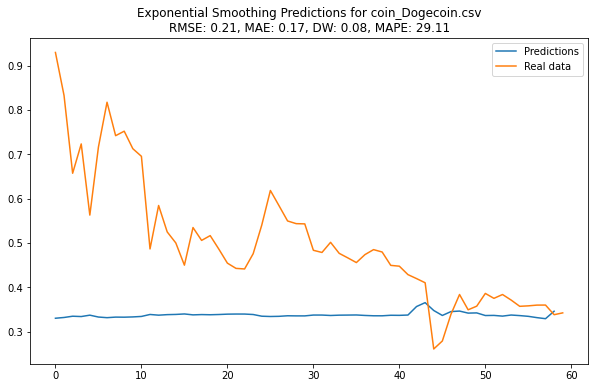

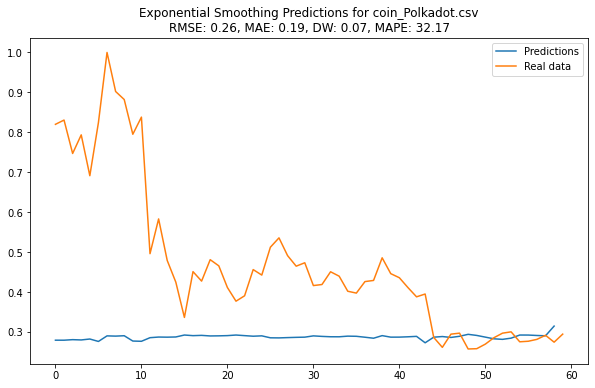

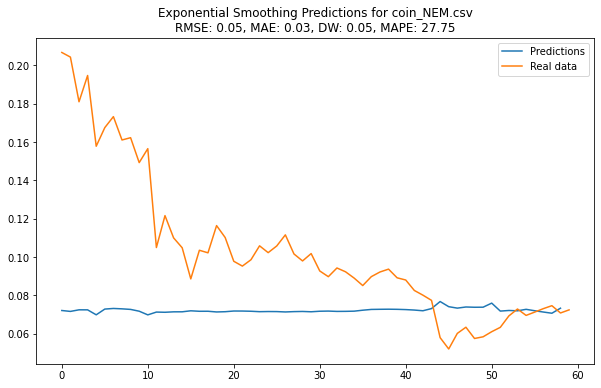

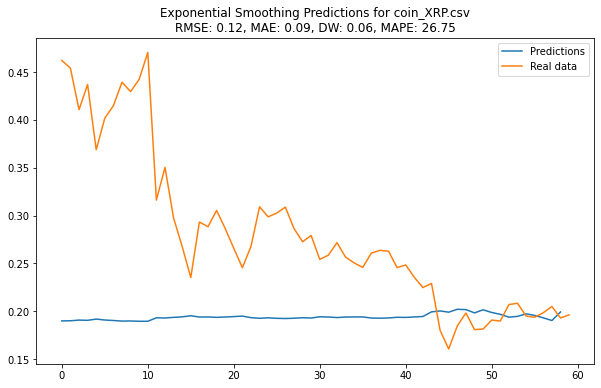

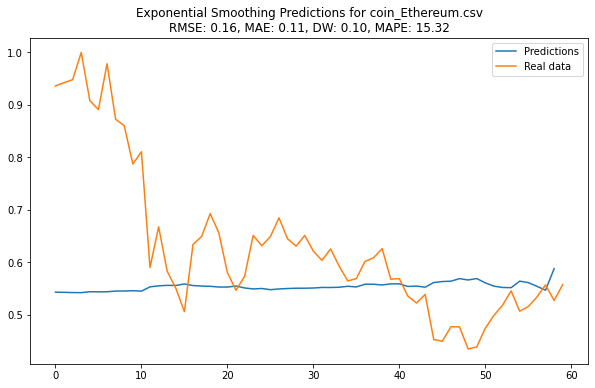

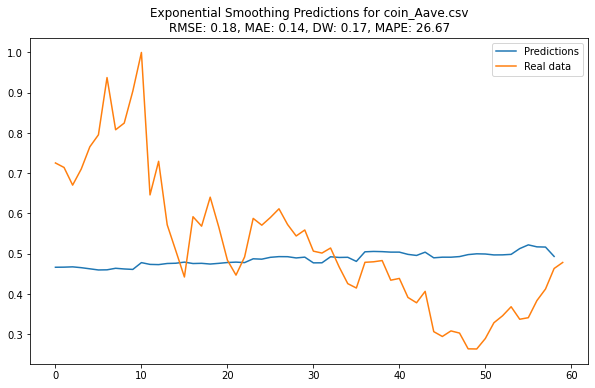

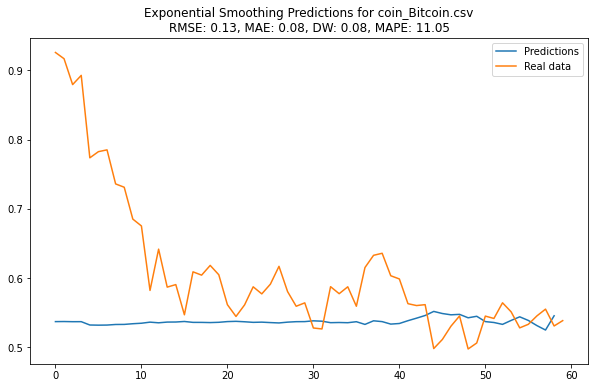

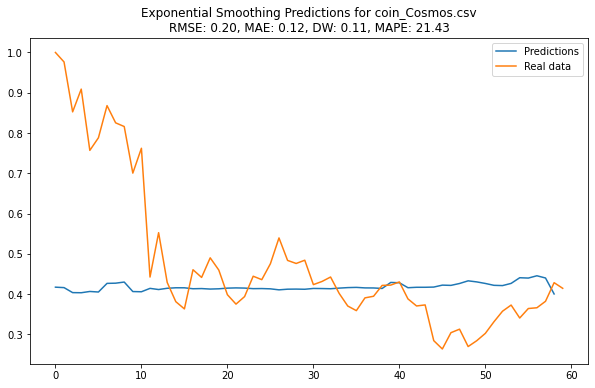

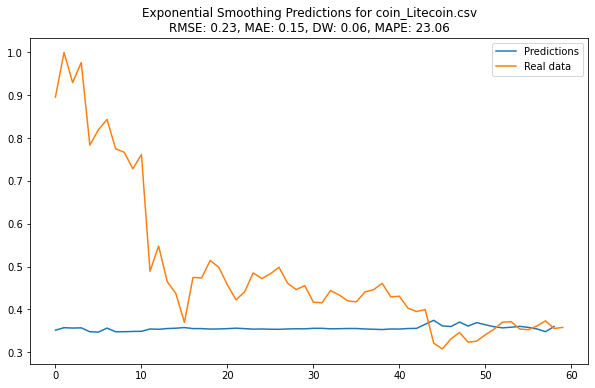

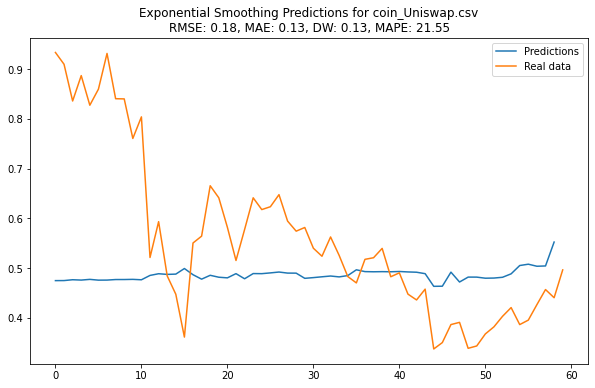

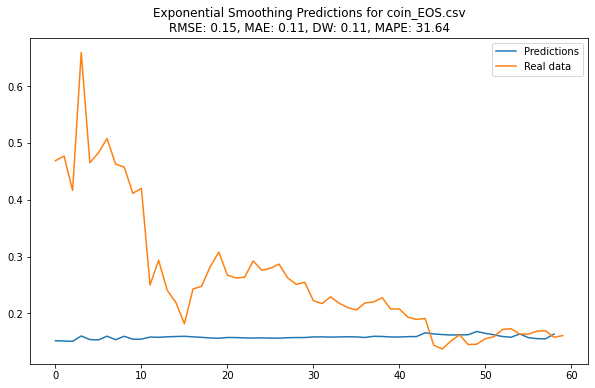

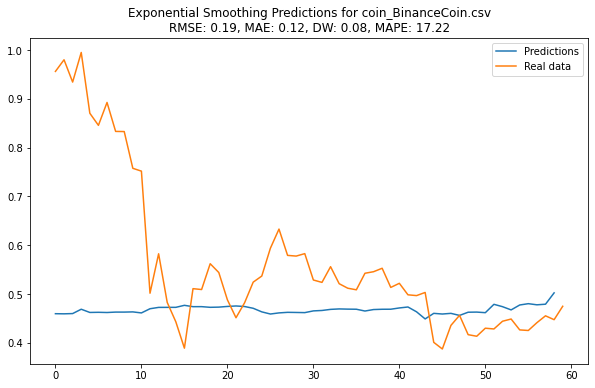

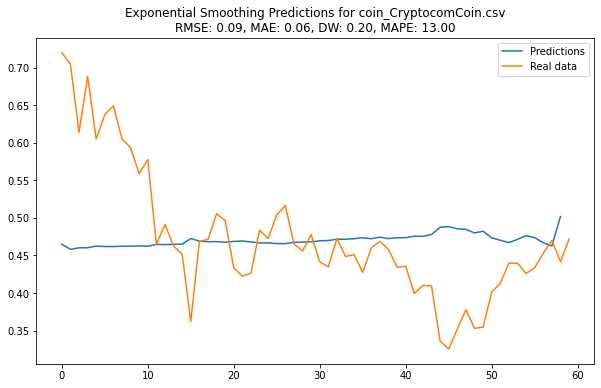

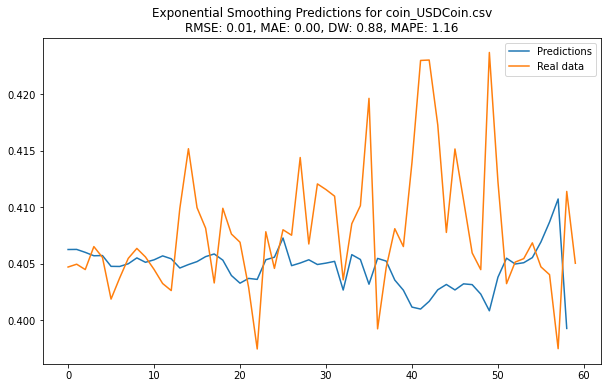

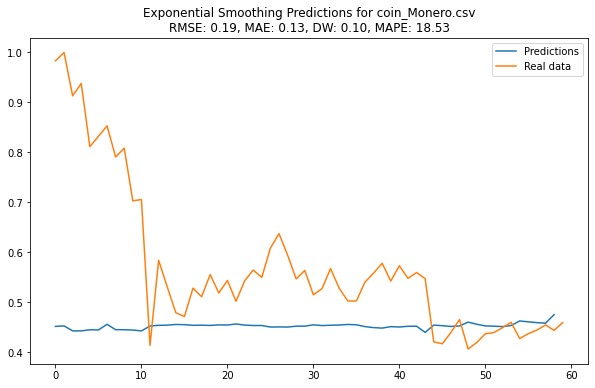

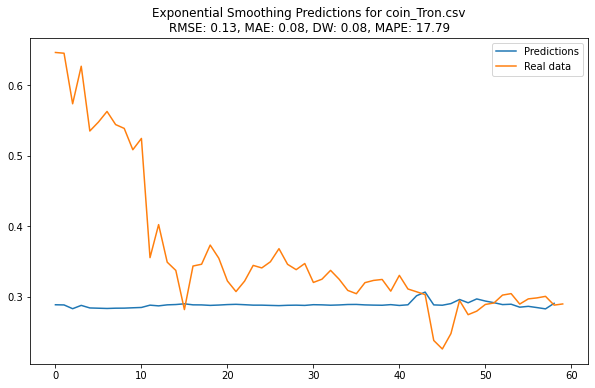

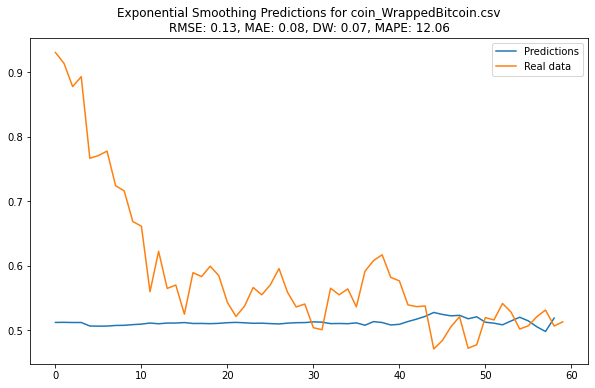

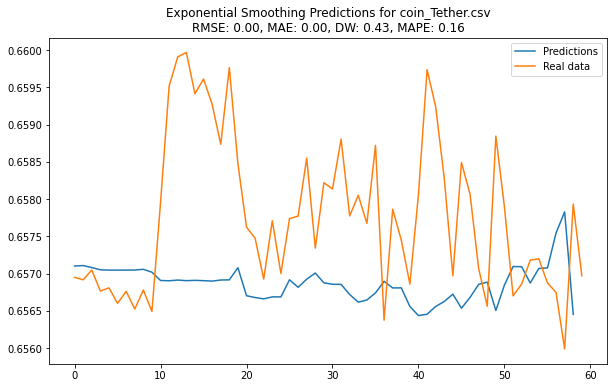

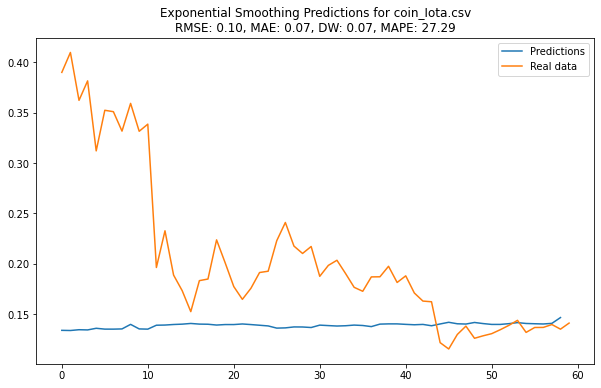

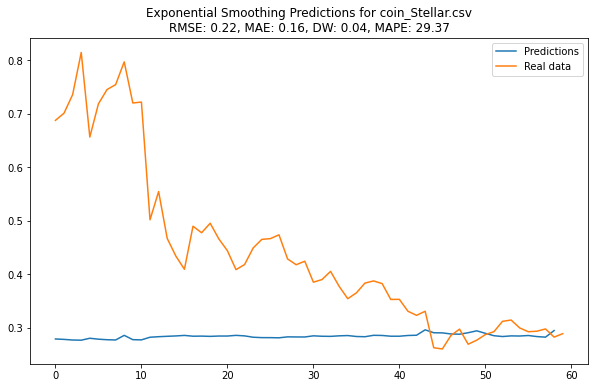

Mean Root Mean Squared Error: 0.14790534199895566
Mean Absolute Error: 0.1026917601388344
Mean Durbin-Watson statistic: 0.16469316328941627
Mean Absolute Percentage Error: 19.735184898363435


In [21]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import warnings
import logging
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Define the directory path of the cryptocurrency price data
data_dir = '/kaggle/input/cryptocurrencypricehistory'

# Get the list of filenames in the directory
filenames = os.listdir(data_dir)

# Disable logging output from Prophet and cmdstanpy
logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled = True

# Create empty lists to store the metrics
rmse_list = []
mae_list = []
dw_list = []
mape_list = []

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")

    # Loop through each cryptocurrency dataset
    for filename in filenames:
        # Read the CSV file
        df = pd.read_csv(os.path.join(data_dir, filename))

        # Preprocess the dataframe
        df = df.rename(columns={"Date": "ds", "Close": "y"})

        # Preprocess the dataframe
        scaler = MinMaxScaler()
        df['y'] = scaler.fit_transform(df['y'].values.reshape(-1, 1))

        # Perform exponential smoothing
        prophet_yhat = []
        for i in range(59):
            # Create a new Exponential Smoothing model
            model = ExponentialSmoothing(df['y'][-60 + i:], trend='add')

            # Fit the model with the data
            model_fit = model.fit()

            # Forecast using Exponential Smoothing
            yhat = model_fit.forecast(steps=1)

            # Scale back the prediction
            prophet_yhat.append(yhat)

        # Scale back the predictions and true values
        real_data = df['y'].values[-60:]
        prophet_yhat = np.array(prophet_yhat)

        # Calculate RMSE
        rmse = np.sqrt(np.mean(((prophet_yhat - real_data) ** 2)))
        rmse_list.append(rmse)

        # Calculate MAE
        mae = np.mean(np.abs(prophet_yhat - real_data))
        mae_list.append(mae)

        # Calculate DW statistic
        residuals = prophet_yhat - real_data
        dw = np.sum(np.diff(residuals) ** 2) / np.sum(residuals ** 2)
        dw_list.append(dw)

        # Calculate MAPE
        mape = np.mean(np.abs((prophet_yhat - real_data) / real_data)) * 100
        mape_list.append(mape)

        # Set the figure size and title
        plt.figure(figsize=(10, 6))
        plt.title(f'Exponential Smoothing Predictions for {filename}\nRMSE: {rmse:.2f}, MAE: {mae:.2f}, DW: {dw:.2f}, MAPE: {mape:.2f}')

        # Plot predictions and true values
        plt.plot(prophet_yhat)
        plt.plot(real_data)
        plt.legend(["Predictions", "Real data"])

        # Show the plot
        plt.show()

# Calculate the mean metrics
mean_rmse = np.mean(rmse_list)
mean_mae = np.mean(mae_list)
mean_dw = np.mean(dw_list)
mean_mape = np.mean(mape_list)

# Print the mean metrics
print("Mean Root Mean Squared Error:", mean_rmse)
print("Mean Absolute Error:", mean_mae)
print("Mean Durbin-Watson statistic:", mean_dw)
print("Mean Absolute Percentage Error:", mean_mape)
